# Conditioning Damped Sinusoids

This notebook is for studies of data conditioning effects for damped sinusoid models, with application to BH ringdown.

Topics include:

* Length of data segment
    - Affects Frequency bin widths, resolution of spikes.
* Sample rate
    - Biases, what method of downsampling is best?
* High and low-pass filtering
    - Dips at low and high frequecies. Digital filter vs. analogue i.e. butterworth. Biases.
* TGR
    - Biases when downsampling
    
Noise generation method: https://gist.github.com/maxisi/7d63b4878a48e5e1c5e0307159bb3e09

In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
import ringdown
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
import matplotlib.patheffects as patheff
from matplotlib.collections import PatchCollection
from matplotlib.legend_handler import HandlerBase
import seaborn as sns
import pandas as pd
import tqdm
import multiprocessing
import arviz as az
import os
from matplotlib.gridspec import GridSpec as gs
import scipy
import random
from tqdm import tqdm
#from sklearn.neighbors import KernelDensity

#Jupyter notebook imports:
sns.set_context('notebook')
sns.set_palette('colorblind')

rng_seed = 3 # 3 is a lucky number
rng = np.random.default_rng(rng_seed) # initialize random seed for all random dists

In [3]:
lalxtra_dir = "/mnt/ceph/users/misi/lscsoft/src/lalsuite-extra/data/lalsimulation" #location of lalsuite-extra, to use NRSur7dq4
db_dir = "/mnt/home/hsiegel/ceph/database_rd/" #absolute path of top level dir for database
os.environ["LAL_DATA_PATH"] = lalxtra_dir
import lal
import lalsimulation as ls
from lalsimulation.nrfits import eval_nrfit

In [4]:
import sys
sys.path.append('/mnt/home/hsiegel/ceph/LineCleaner')
from line_cleaner import clean_strain

## Methods

In [5]:
def damped_sinusoid(A,f,gamma,phase,times,verbose = False, reflect = True):
    #Create a time series for a damped sinusoid.
    #A: float, amplitude
    #f: float, central frequency
    #gamma: float, damping rate
    #phase: float, 0 to 2pi, phase of sinusoid
    #times: array, list of times to calculate damped sinusoid for, starting from peak of signal
    #verbose: bool, if True then print time series of damped sinusoid
    #reflect: bool, if True then reflect damped sinusoid at early times to make a "ring-up"
    
    t0 = times[0]
    times_input = times-t0 # rescale times for damped sinusoid functional input
    sin_func = A*np.cos(2*np.pi*f*times_input+phase)*np.exp(-gamma*times_input)
    if reflect:
        times = np.append(times-times_input[-1]-times_input[1],times)
        times_input = np.append(times_input-times_input[-1]-times_input[1],times_input)
        sin_func = A*np.cos(2*np.pi*f*times_input+phase)*np.exp(-gamma*abs(times_input))
    
    damped_sin = ringdown.TimeSeries(sin_func,times)
    
    if verbose:
        print(damped_sin)
        
    return damped_sin

In [6]:
def laldesignpsd(freqs):
    #freqs: frequencies at which to compute PSD
    #returns ringdown PowerSpectrum of design sensitivity PSD with no signal cavity detuning and high laser power

    laldesignpsd = []
    for x in freqs:
        laldesignpsd.append( ls.SimNoisePSDaLIGOZeroDetHighPower(x))

    if np.isnan(laldesignpsd[0]):
        laldesignpsd[0] = laldesignpsd[1]

    laldesignpsd = ringdown.PowerSpectrum(laldesignpsd, freqs)
    
    return laldesignpsd

In [7]:
def generate_noise(dur=128, sr=2**14, scale=1.5e-45, spike_amp = None, spike_mean = None, spike_std = None, rtrn_psd = False, lalpsd = False,lorentzian = True):
    #Generate noise for a given length of time and sample rate
    #dur: float, length of time to generate noise for
    #sr: float, sample rate
    #scale: float, magnitude of PSD
    #lalpsd: bool, if False then generate white noise / white noise with spike, if True then generate LIGO PSD / with spike
    #lorentzian: bool, if True then add Lorentzian when adding spike, else add Gaussian
    
    N = int(dur * sr)
    delta_t = 1/sr
    freqs = np.fft.rfftfreq(N, delta_t)
    delta_f = freqs[1] - freqs[0]
    times = np.arange(0 , dur, delta_t)
    
    if lalpsd:
        psd = []
        for x in freqs:
            psd.append( ls.SimNoisePSDaLIGOZeroDetHighPower(x))
        if np.isnan(psd[0]):
            psd[0] = psd[1]

    else:
        psd = np.ones(len(freqs))*scale
    
    if (spike_amp is not None and spike_mean is not None and spike_std is not None):
        if lorentzian:
            psd += spike_amp*spike_std/((2*np.pi)*((freqs-spike_mean)**2+(spike_std**2)/4)) #Lorentzian spike
            print("Adding Lorentzian spike to PSD")
        else:
            psd += spike_amp*np.exp(-0.5*((freqs-spike_mean)/spike_std)**2) #Gaussian spike
            print("Adding Gaussian spike to PSD")
    
    var = psd / (4.*delta_f)
    noise_real = rng.normal(size=len(psd), loc=0, scale=np.sqrt(var))
    noise_imag = rng.normal(size=len(psd), loc=0, scale=np.sqrt(var))
    noise_fd = noise_real + 1j*noise_imag
    
    noise_td = ringdown.TimeSeries(np.fft.irfft(noise_fd) / delta_t,times)
    psd = ringdown.PowerSpectrum(psd, freqs)
    
    if rtrn_psd:
        return noise_td, psd
    
    else:
        return noise_td

In [8]:
def np2(x): #Get next power of two
    p = 1
    while p <= x:
        p = p << 1
    return p

# GW150914-like signal, different downsampling

## Digital Filter vs Analog

In [9]:
sample_rate = 2**14
duration = 4096
noise_td, psd = generate_noise(lalpsd = True, rtrn_psd = True, dur=duration)

In [10]:
times = noise_td.index
t0 = duration/2

f_qnm = 250 # https://arxiv.org/pdf/2107.05609.pdf Table 1
A = 3e-21
tau_qnm = 4e-3
phase_qnm = 5.34 # radians
signal = damped_sinusoid(A=A, f=f_qnm, gamma=1/tau_qnm, phase=phase_qnm, times=times[int(len(times)/2):])

In [202]:
dur = 0.05 #signal data segment duration
flow = 1/dur
draws = 2000
#ifo = "L1"

# fit_dict_fundamental = {}

# for ds in [1,4,8,16,32]:
#     fit = ringdown.Fit(modes=[(1, -2, 2, 2, 0)])
#     fit.set_target(t0, duration=dur)
#     fit.add_data(signal)
#     fit.update_prior(a_scale_max=10*A, m_min=35.0, m_max=140.0)
#     fit.condition_data(f_min=flow,ds=ds,digital_filter=True)
#     nperseg = np2(16*fit.duration*(sample_rate)/ds)
    
#     fit2 = ringdown.Fit(modes=[(1, -2, 2, 2, 0)])
#     fit2.set_target(t0, duration=dur)
#     fit2.add_data(signal+noise_td)
#     fit2.condition_data(f_min=flow,ds=ds,digital_filter=True)
#     fit2.compute_acfs(method='fd', nperseg=nperseg, f_min = flow) # flattened PSD

#     fit.acfs=fit2.acfs
#     acfs_name_str = "/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/ACF_GW150914_NOnoise_LIGOWelchPSDDigitalFilter_fundamental_dur{d}_flow{f}_ds{k}.csv".format(
#                 d=str(dur).replace(".","p"), k = ds,f=str(flow).replace(".","p"))
#     fit2.acfs[None].to_csv(acfs_name_str)
    
#     fit.run(num_samples=draws)
#     fit_dict_fundamental[ds] = fit
    
# for k,v in fit_dict_fundamental.items():
#     print(k)
#     name_str = "/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW150914_NOnoise_LIGOWelchPSDDigitalFilter_fundamental_ds{k}_dur{d}s_flow{fl}__A{a}_f{f}_ph{p}_tau{t}.nc".format(
#         k=k,d=str(dur).replace(".","p"),a=str(A).replace(".","p"),f=str(f_qnm),p=str(phase_qnm).replace(".","p"),t=str(tau_qnm).replace(".","p"),fl=str(flow).replace(".","p"))
#     print(name_str)
#     v.result.to_netcdf(name_str)

fit_dict_fundamental = {}

for ds in [1,4,8,16,32]:
    fit = ringdown.Fit(modes=[(1, -2, 2, 2, 0)])
    fit.set_target(t0, duration=dur)
    fit.add_data(signal)
    fit.update_prior(a_scale_max=10*A, m_min=35.0, m_max=140.0)
    fit.condition_data(f_min=flow,ds=ds,digital_filter=False)
    nperseg = np2(16*fit.duration*(sample_rate)/ds)
    
    fit2 = ringdown.Fit(modes=[(1, -2, 2, 2, 0)])
    fit2.set_target(t0, duration=dur)
    fit2.add_data(signal+noise_td)
    fit2.condition_data(f_min=flow,ds=ds,digital_filter=False)
    fit2.compute_acfs(method='fd', nperseg=nperseg, f_min = flow) # flattened PSD

    fit.acfs=fit2.acfs
    acfs_name_str = "/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/ACF_GW150914_NOnoise_LIGOWelchPSDAnalogFilter_fundamental_dur{d}_flow{f}_ds{k}.csv".format(
                d=str(dur).replace(".","p"), k = ds,f=str(flow).replace(".","p"))
    fit2.acfs[None].to_csv(acfs_name_str)
    fit.run(num_samples=draws)
    fit_dict_fundamental[ds] = fit
    
for k,v in fit_dict_fundamental.items():
    print(k)
    name_str = "/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW150914_NOnoise_LIGOWelchPSDAnalogFilter_fundamental_ds{k}_dur{d}s_flow{fl}__A{a}_f{f}_ph{p}_tau{t}.nc".format(
        k=k,d=str(dur).replace(".","p"),a=str(A).replace(".","p"),f=str(f_qnm),p=str(phase_qnm).replace(".","p"),t=str(tau_qnm).replace(".","p"),fl=str(flow).replace(".","p"))
    print(name_str)
    v.result.to_netcdf(name_str)

/mnt/home/hsiegel/ringdown/ringdown/fit.py:254: UserWarning: update_prior is deprecated, use update_model instead
  warnings.warn("update_prior is deprecated, use update_model instead")


None {None: 2048.0}
None {None: 2048.0}
None {None: 2048.0}
None {None: 2048.0}
None {None: 2048.0}
None {None: 2048.0}


warmup:   1%|          | 35/3000 [00:05<07:59,  6.18it/s, 63 steps of size 2.86e-02. acc. prob=0.74] 

KeyboardInterrupt



## TGR

In [19]:
times = noise_td.index
t0 = duration/2

qnm1 = ringdown.qnms.get_ftau(68,0.69,0,2,2) # GW150914
qnm2 = ringdown.qnms.get_ftau(68,0.69,1,2,2)
f_qnm = [qnm1[0],qnm2[0]] # https://arxiv.org/pdf/2107.05609.pdf Table 1
A = [3e-21*1.5,4e-21*1.5]
tau_qnm = [qnm1[1],qnm2[1]]
phase_qnm = [5.34, 1.79]

signal1 = damped_sinusoid(A=A[0], f=f_qnm[0], gamma=1/tau_qnm[0], phase=phase_qnm[0], times=times[int(len(times)/2):])
signal2 = damped_sinusoid(A=A[1], f=f_qnm[1], gamma=1/tau_qnm[1], phase=phase_qnm[1], times=times[int(len(times)/2):])

signal = signal1 + signal2

In [90]:
dur = 0.05 #signal data segment duration
flow = 1/dur
draws = 2000
#ifo = "L1"

# fit_dict_fundamental = {}

# for ds in [1,4,8,16,32]:
#     fit = ringdown.Fit(modes=[(1, -2, 2, 2, 0),(1, -2, 2, 2, 1)])
#     fit.set_target(t0, duration=dur)
#     fit.add_data(signal)
#     fit.update_prior(a_scale_max=10*max(A), m_min=35.0, m_max=140.0)
#     fit.condition_data(f_min=flow,ds=ds,digital_filter=True)
#     nperseg = np2(16*fit.duration*(sample_rate)/ds)
    
#     fit2 = ringdown.Fit(modes=[(1, -2, 2, 2, 0),(1, -2, 2, 2, 1)])
#     fit2.set_target(t0, duration=dur)
#     fit2.add_data(signal+noise_td)
#     fit2.condition_data(f_min=flow,ds=ds,digital_filter=True)
#     fit2.compute_acfs(method='fd', nperseg=nperseg, f_min = flow) # flattened PSD

#     fit.acfs=fit2.acfs
#     acfs_name_str = "/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/ACF_2modes_GW150914_NOnoise_LIGOWelchPSDDigitalFilter_fundamental_dur{d}_flow{f}_ds{k}.csv".format(
#                 d=str(dur).replace(".","p"), k = ds,f=str(flow).replace(".","p"))
#     fit2.acfs[None].to_csv(acfs_name_str)
    
#     fit.run(num_samples=draws)
#     fit_dict_fundamental[ds] = fit
    
# for k,v in fit_dict_fundamental.items():
#     print(k)
#     name_str = "/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW150914_NOnoise_LIGOWelchPSDDigitalFilter_fundamental_ds{k}_dur{d}s_flow{fl}_A1{a}_f1{f}_ph1{p}_tau1{t}_A2{a2}_f2{f2}_ph2{p2}_tau2{t2}.nc".format(
#         k=k,d=str(dur).replace(".","p"),a=str(A[0]).replace(".","p"),f=str(f_qnm[0]),p=str(phase_qnm[0]).replace(".","p"),t=str(tau_qnm[0]).replace(".","p"),fl=str(flow).replace(".","p"),
#         a2=str(A[1]).replace(".","p"),f2=str(f_qnm[1]),p2=str(phase_qnm[1]).replace(".","p"),t2=str(tau_qnm[1]).replace(".","p"))
#     print(name_str)
#     v.result.to_netcdf(name_str)
    
fit_dict_fundamental = {}

for ds in [1,4,8,16,32]:
    fit = ringdown.Fit(modes=[(1, -2, 2, 2, 0),(1, -2, 2, 2, 1)])
    fit.set_target(t0, duration=dur)
    fit.add_data(signal)
    fit.update_prior(a_scale_max=10*max(A), m_min=35.0, m_max=140.0)
    fit.condition_data(f_min=flow,ds=ds,digital_filter=False)
    nperseg = np2(16*fit.duration*(sample_rate)/ds)
    
    fit2 = ringdown.Fit(modes=[(1, -2, 2, 2, 0),(1, -2, 2, 2, 1)])
    fit2.set_target(t0, duration=dur)
    fit2.add_data(signal+noise_td)
    fit2.condition_data(f_min=flow,ds=ds,digital_filter=False)
    fit2.compute_acfs(method='fd', nperseg=nperseg, f_min = flow) # flattened PSD

    fit.acfs=fit2.acfs
    
    fit.run(num_samples=draws)
    fit_dict_fundamental[ds] = fit
    
for k,v in fit_dict_fundamental.items():
    print(k)
    name_str = "/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW150914_NOnoise_LIGOWelchPSDAnalogFilter_fundamental_ds{k}_dur{d}s_flow{fl}_A1{a}_f1{f}_ph1{p}_tau1{t}_A2{a2}_f2{f2}_ph2{p2}_tau2{t2}.nc".format(
        k=k,d=str(dur).replace(".","p"),a=str(A[0]).replace(".","p"),f=str(f_qnm[0]),p=str(phase_qnm[0]).replace(".","p"),t=str(tau_qnm[0]).replace(".","p"),fl=str(flow).replace(".","p"),
        a2=str(A[1]).replace(".","p"),f2=str(f_qnm[1]),p2=str(phase_qnm[1]).replace(".","p"),t2=str(tau_qnm[1]).replace(".","p"))
    print(name_str)
    v.result.to_netcdf(name_str)
    
fit_dict_fundamental = {}

for ds in [1,4,8,16,32]:
    fit = ringdown.Fit(modes=[(1, -2, 2, 2, 0),(1, -2, 2, 2, 1)])
    fit.set_target(t0, duration=dur)
    fit.add_data(signal)
    fit.update_prior(a_scale_max=10*max(A), m_min=35.0, m_max=140.0,df_min=[None,-0.5],df_max=[None,0.5],dg_min=[None,-0.5],dg_max=[None,0.5])
    fit.condition_data(f_min=flow,ds=ds,digital_filter=True)
    nperseg = np2(16*fit.duration*(sample_rate)/ds)
    
    fit2 = ringdown.Fit(modes=[(1, -2, 2, 2, 0),(1, -2, 2, 2, 1)])
    fit2.set_target(t0, duration=dur)
    fit2.add_data(signal+noise_td)
    fit2.condition_data(f_min=flow,ds=ds,digital_filter=True)
    fit2.compute_acfs(method='fd', nperseg=nperseg, f_min = flow) # flattened PSD

    fit.acfs=fit2.acfs
    
    fit.run(num_samples=draws)
    fit_dict_fundamental[ds] = fit
    
for k,v in fit_dict_fundamental.items():
    print(k)
    name_str = "/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/TGR_GW150914_NOnoise_LIGOWelchPSDDigitalFilter_fundamental_ds{k}_dur{d}s_flow{fl}_A1{a}_f1{f}_ph1{p}_tau1{t}_A2{a2}_f2{f2}_ph2{p2}_tau2{t2}.nc".format(
        k=k,d=str(dur).replace(".","p"),a=str(A[0]).replace(".","p"),f=str(f_qnm[0]),p=str(phase_qnm[0]).replace(".","p"),t=str(tau_qnm[0]).replace(".","p"),fl=str(flow).replace(".","p"),
        a2=str(A[1]).replace(".","p"),f2=str(f_qnm[1]),p2=str(phase_qnm[1]).replace(".","p"),t2=str(tau_qnm[1]).replace(".","p"))
    print(name_str)
    v.result.to_netcdf(name_str)

/mnt/home/hsiegel/ringdown/ringdown/fit.py:254: UserWarning: update_prior is deprecated, use update_model instead
  warnings.warn("update_prior is deprecated, use update_model instead")
sample: 100%|██████████| 3000/3000 [01:36<00:00, 31.08it/s, 7 steps of size 3.77e-01. acc. prob=0.95] 
/mnt/home/hsiegel/ringdown/ringdown/fit.py:254: UserWarning: update_prior is deprecated, use update_model instead
  warnings.warn("update_prior is deprecated, use update_model instead")
sample: 100%|██████████| 3000/3000 [00:11<00:00, 270.76it/s, 7 steps of size 4.54e-01. acc. prob=0.88] 
/mnt/home/hsiegel/ringdown/ringdown/fit.py:254: UserWarning: update_prior is deprecated, use update_model instead
  warnings.warn("update_prior is deprecated, use update_model instead")
sample: 100%|██████████| 3000/3000 [00:06<00:00, 453.76it/s, 7 steps of size 3.13e-01. acc. prob=0.93] 
/mnt/home/hsiegel/ringdown/ringdown/fit.py:254: UserWarning: update_prior is deprecated, use update_model instead
  warnings.warn("

1
/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW150914_NOnoise_LIGOWelchPSDAnalogFilter_fundamental_ds1_dur0p05s_flow20p0_A14p5e-21_f1251.00199551019213_ph15p34_tau10p004126712034976184_A25p999999999999999e-21_f2245.42368760857954_ph21p79_tau20p0013647824422501954.nc
4
/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW150914_NOnoise_LIGOWelchPSDAnalogFilter_fundamental_ds4_dur0p05s_flow20p0_A14p5e-21_f1251.00199551019213_ph15p34_tau10p004126712034976184_A25p999999999999999e-21_f2245.42368760857954_ph21p79_tau20p0013647824422501954.nc
8
/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW150914_NOnoise_LIGOWelchPSDAnalogFilter_fundamental_ds8_dur0p05s_flow20p0_A14p5e-21_f1251.00199551019213_ph15p34_tau10p004126712034976184_A25p999999999999999e-21_f2245.42368760857954_ph21p79_tau20p0013647824422501954.nc
16
/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW150914_NOnoise_LIGOWelchPSDAnalogFilter_fundamental_ds16_dur0p05s_flow2

/mnt/home/hsiegel/ringdown/ringdown/fit.py:254: UserWarning: update_prior is deprecated, use update_model instead
  warnings.warn("update_prior is deprecated, use update_model instead")
sample: 100%|██████████| 3000/3000 [02:27<00:00, 20.30it/s, 7 steps of size 3.11e-01. acc. prob=0.94] 
/mnt/home/hsiegel/ringdown/ringdown/fit.py:254: UserWarning: update_prior is deprecated, use update_model instead
  warnings.warn("update_prior is deprecated, use update_model instead")
sample: 100%|██████████| 3000/3000 [00:17<00:00, 167.23it/s, 15 steps of size 3.95e-01. acc. prob=0.89]
/mnt/home/hsiegel/ringdown/ringdown/fit.py:254: UserWarning: update_prior is deprecated, use update_model instead
  warnings.warn("update_prior is deprecated, use update_model instead")
sample: 100%|██████████| 3000/3000 [00:10<00:00, 281.64it/s, 15 steps of size 3.16e-01. acc. prob=0.94]
/mnt/home/hsiegel/ringdown/ringdown/fit.py:254: UserWarning: update_prior is deprecated, use update_model instead
  warnings.warn("

1
/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/TGR_GW150914_NOnoise_LIGOWelchPSDDigitalFilter_fundamental_ds1_dur0p05s_flow20p0_A14p5e-21_f1251.00199551019213_ph15p34_tau10p004126712034976184_A25p999999999999999e-21_f2245.42368760857954_ph21p79_tau20p0013647824422501954.nc
4
/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/TGR_GW150914_NOnoise_LIGOWelchPSDDigitalFilter_fundamental_ds4_dur0p05s_flow20p0_A14p5e-21_f1251.00199551019213_ph15p34_tau10p004126712034976184_A25p999999999999999e-21_f2245.42368760857954_ph21p79_tau20p0013647824422501954.nc
8
/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/TGR_GW150914_NOnoise_LIGOWelchPSDDigitalFilter_fundamental_ds8_dur0p05s_flow20p0_A14p5e-21_f1251.00199551019213_ph15p34_tau10p004126712034976184_A25p999999999999999e-21_f2245.42368760857954_ph21p79_tau20p0013647824422501954.nc
16
/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/TGR_GW150914_NOnoise_LIGOWelchPSDDigitalFilter_fundamental

### Design PSD Runs

In [16]:
dur = 0.05 #signal data segment duration
flow = 10
draws = 2000
#ifo = "L1"
delta_t = 1/sample_rate

fit_dict_fundamental = {}

for ds in [32]:#[1,4,8,16]:
    noise_td2, psd_analysis = generate_noise(sr=sample_rate/ds, rtrn_psd=True, lalpsd = True)
    acf_analysis = psd_analysis.to_acf()
    analysis_data = ringdown.Data(signal,noise_td.index)
    analysis_data_cond = analysis_data.condition(t0=t0,ds=ds,digital_filter = True)
    #fit = ringdown.Fit('ftau', modes=1)
    #fit = ringdown.Fit('mchi', modes = [(1, -2, 2, 2, 0)])
    fit = ringdown.Fit(modes=[(1, -2, 2, 2, 0)])
    
    
    incr = 0
    running = False
    while not running:
        data_dur = dur+incr*delta_t
        freqs_analysis = np.fft.rfftfreq(len(analysis_data_cond[t0:t0+data_dur]), delta_t*ds)
        fit.add_data(analysis_data_cond[t0:t0+data_dur], acf=acf_analysis[0:data_dur], ifo='X')
        fit.set_target(t0, duration=data_dur)
        fit.update_prior(a_scale_max=10*A, m_min=35.0, m_max=140.0)
        if incr>ds*2:
            raise ValueError("Something is broken in this loop")
        elif len(fit.data[None])!=len(fit.acfs[None]):
            print(len(fit.data[None]))
            print(len(fit.acfs[None]))
            incr+=1
        else:
            running = True
    print("Analysis segment duration =",data_dur)
    print("Running with downsampling",ds)
    
    fit.run(num_samples = draws)
    fit_dict_fundamental[ds] = fit
    
for k,v in fit_dict_fundamental.items():
    print(k)
    name_str = "/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/TEST_GW150914_NOnoise_LIGOWelchPSDDigitalFilter_fundamental_ds{k}_dur{d}s_A{a}_f{f}_ph{p}_tau{t}.nc".format(
        k=k,d=str(dur).replace(".","p"),a=str(A).replace(".","p"),f=str(f_qnm),p=str(phase_qnm).replace(".","p"),t=str(tau_qnm).replace(".","p"))
    print(name_str)
    v.result.to_netcdf(name_str)

# fit_dict_fundamental = {}

# for ds in [1,4,8,16]:
#     fit = ringdown.Fit(modes=[(1, -2, 2, 2, 0)])
#     fit.set_target(t0, duration=dur)
#     fit.add_data(signal)
#     fit.update_prior(a_scale_max=10*A, m_min=35.0, m_max=140.0)
#     fit.condition_data(f_min=flow,ds=ds,digital_filter=False)
#     nperseg = np2(16*fit.duration*(sample_rate)/ds)
    
#     fit2 = ringdown.Fit(modes=[(1, -2, 2, 2, 0)])
#     fit2.set_target(t0, duration=dur)
#     fit2.add_data(signal+noise_td)
#     fit2.condition_data(f_min=flow,ds=ds,digital_filter=False)
#     fit2.compute_acfs(method='fd', nperseg=nperseg, f_min = flow) # flattened PSD

#     fit.acfs=fit2.acfs
#     acfs_name_str = "/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/ACF_GW150914_NOnoise_LIGOWelchPSDAnalogFilter_fundamental_dur{d}_ds{k}.csv".format(
#                 d=str(dur).replace(".","p"), k = ds)
#     fit2.acfs[None].to_csv(acfs_name_str)
#     fit.run(num_samples=draws)
#     fit_dict_fundamental[ds] = fit
    
# for k,v in fit_dict_fundamental.items():
#     print(k)
#     name_str = "/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW150914_NOnoise_LIGOWelchPSDAnalogFilter_fundamental_ds{k}_dur{d}s_A{a}_f{f}_ph{p}_tau{t}.nc".format(
#        k=k,d=str(dur).replace(".","p"),a=str(A).replace(".","p"),f=str(f_qnm),p=str(phase_qnm).replace(".","p"),t=str(tau_qnm).replace(".","p"))
#     print(name_str)
#     v.result.to_netcdf(name_str)

None {None: 2048.0}
Analysis segment duration = 0.05
Running with downsampling 32
None {None: 2048.0}
None {None: 2048.0}
None {None: 2048.0}
None {None: 2048.0}


/mnt/home/hsiegel/ringdown/ringdown/fit.py:254: UserWarning: update_prior is deprecated, use update_model instead
  warnings.warn("update_prior is deprecated, use update_model instead")
sample: 100%|██████████| 3000/3000 [00:03<00:00, 845.18it/s, 7 steps of size 2.03e-01. acc. prob=0.84]  


32
/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/TEST_GW150914_NOnoise_LIGOWelchPSDDigitalFilter_fundamental_ds32_dur0p05s_A3e-21_f250_ph5p34_tau0p004.nc


In [ ]:
segment=0

data_FT = np.fft.rfft(analysis_data.values[nperseg*segment:nperseg*(segment+1)])*ds/sample_rate # multiply by 2 to get power right
maxs_plot = data_FT.real/np.sqrt(fit.acfs[None].to_psd() * fit.acfs[None].to_psd().delta_f / 4)
plt.plot(maxs_plot[1:])

# GW190521-like signal, different duration

## Spike

In [253]:
sample_rate = 2**12
duration = 4096

#signal parameters
f_qnm = 67.489
A = 1.2e-21
tau_qnm = 0.0155
phase_qnm = 5.34 # radians

# PSD parameters
spike_std = 0.05
spike_mean = f_qnm
spike_amp = 1.5e-45

noise_td, psd_analysis = generate_noise(sr=sample_rate, rtrn_psd=True, lalpsd = True, dur=duration,
                                            spike_mean=spike_mean, spike_std=spike_std, spike_amp = spike_amp)
times = noise_td.index

signal = damped_sinusoid(A=A, f=f_qnm, gamma=1/tau_qnm, phase=phase_qnm, times=times[int(len(times)/2):])

t0 = duration/2

Adding Lorentzian spike to PSD


In [255]:
# fit_dict_fundamental = {}
# ds = 1

# for dur in [0.05,0.1,0.2]:
#     flow = max(1/dur, 10)
#     fit = ringdown.Fit(modes=[(1, -2, 2, 2, 0)])
#     fit.set_target(t0, duration=dur)
#     fit.add_data(signal)
#     fit.update_prior(a_scale_max=10*A, m_min=250/2, m_max=250*2)
#     fit.condition_data(f_min=flow,ds=ds,digital_filter=True)
#     nperseg = np2(16*fit.duration*(sample_rate)/ds)
    
#     fit2 = ringdown.Fit(modes=[(1, -2, 2, 2, 0)])
#     fit2.set_target(t0, duration=dur)
#     fit2.add_data(signal+noise_td)
#     fit2.condition_data(f_min=flow,ds=ds,digital_filter=True)
#     fit2.compute_acfs(method='fd', nperseg=nperseg, f_min = flow) # flattened PSD

#     fit.acfs=fit2.acfs
#     acfs_name_str = "/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/ACF_GW190521_NOnoise_LIGOWelchPSDDigitalFilter_fundamental_dur{d}_flow{f}_ds{k}.csv".format(
#                 d=str(dur).replace(".","p"), k = ds,f=str(flow).replace(".","p"))
#     fit2.acfs[None].to_csv(acfs_name_str)
#     fit.run(num_samples=draws)
#     fit_dict_fundamental[dur] = fit

acfs_name_str = "/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/ACF_GW190521_NOnoise_LIGOWelchPSDDigitalFilterLorentzianspike_fundamental_dur{d}_flow{f}_ds{k}.csv".format(
            d=str(dur).replace(".","p"), k = ds,f=str(flow).replace(".","p"))
fit2.acfs[None].to_csv(acfs_name_str)

    
for k,v in fit_dict_fundamental.items():
    print(k)
    name_str = "/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW190521_NOnoise_LIGOWelchPSDDitialFilterLorentzianspike_fundamental_ds{k}_sr{r}_dur{d}s_A{a}_f{f}_ph{p}_tau{t}_spikeA{spA}M{spM}S{spS}.nc".format(
        k=ds,d=str(k).replace(".","p"),r=str(int(sample_rate)),a=str(A).replace(".","p"),f=str(f_qnm).replace(".","p"),p=str(phase_qnm).replace(".","p"),t=str(tau_qnm).replace(".","p"),
        spA=str(spike_amp).replace(".","p"),spM=str(spike_mean).replace(".","p"),spS=str(spike_std).replace(".","p"))
    print(name_str)
    v.result.to_netcdf(name_str)

0.05
/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW190521_NOnoise_LIGOWelchPSDDitialFilterLorentzianspike_fundamental_ds1_sr4096_dur0p05s_A1p2e-21_f67p489_ph5p34_tau0p0155_spikeA1p5e-45M67p489S0p05.nc
0.1
/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW190521_NOnoise_LIGOWelchPSDDitialFilterLorentzianspike_fundamental_ds1_sr4096_dur0p1s_A1p2e-21_f67p489_ph5p34_tau0p0155_spikeA1p5e-45M67p489S0p05.nc
0.2
/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW190521_NOnoise_LIGOWelchPSDDitialFilterLorentzianspike_fundamental_ds1_sr4096_dur0p2s_A1p2e-21_f67p489_ph5p34_tau0p0155_spikeA1p5e-45M67p489S0p05.nc


## No Spike

In [256]:
sample_rate = 2**12
duration = 4096

#signal parameters
f_qnm = 67.489
A = 1.2e-21
tau_qnm = 0.0155
phase_qnm = 5.34 # radians

# PSD parameters
noise_td, psd_analysis = generate_noise(sr=sample_rate, rtrn_psd=True, lalpsd = True, dur=duration)

times = noise_td.index

signal = damped_sinusoid(A=A, f=f_qnm, gamma=1/tau_qnm, phase=phase_qnm, times=times[int(len(times)/2):])

t0 = duration/2

In [257]:
fit_dict_fundamental = {}
ds = 1

for dur in [0.05]:
    flow = max(1/dur, 10)
    fit = ringdown.Fit(modes=[(1, -2, 2, 2, 0)])
    fit.set_target(t0, duration=dur)
    fit.add_data(signal)
    fit.update_prior(a_scale_max=10*A, m_min=250/2, m_max=250*2)
    fit.condition_data(f_min=flow,ds=ds,digital_filter=True)
    nperseg = np2(16*fit.duration*(sample_rate)/ds)
    
    fit2 = ringdown.Fit(modes=[(1, -2, 2, 2, 0)])
    fit2.set_target(t0, duration=dur)
    fit2.add_data(signal+noise_td)
    fit2.condition_data(f_min=flow,ds=ds,digital_filter=True)
    fit2.compute_acfs(method='fd', nperseg=nperseg, f_min = flow) # flattened PSD

    fit.acfs=fit2.acfs
    acfs_name_str = "/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/ACF_GW190521_NOnoise_LIGOWelchPSDDigitalFilterNOSPIKE_fundamental_dur{d}_flow{f}_ds{k}.csv".format(
                d=str(dur).replace(".","p"), k = ds,f=str(flow).replace(".","p"))
    fit2.acfs[None].to_csv(acfs_name_str)
    fit.run(num_samples=draws)
    fit_dict_fundamental[dur] = fit
    
for k,v in fit_dict_fundamental.items():
    print(k)
    name_str = "/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW190521_NOnoise_LIGOWelchPSDDitialFilter_fundamental_ds{k}_sr{r}_dur{d}s_A{a}_f{f}_ph{p}_tau{t}.nc".format(
        k=ds,d=str(k).replace(".","p"),r=str(int(sample_rate)),a=str(A).replace(".","p"),f=str(f_qnm).replace(".","p"),p=str(phase_qnm).replace(".","p"),t=str(tau_qnm).replace(".","p"),
        spA=str(spike_amp).replace(".","p"),spM=str(spike_mean).replace(".","p"),spS=str(spike_std).replace(".","p"))
    print(name_str)
    v.result.to_netcdf(name_str)

/mnt/home/hsiegel/ringdown/ringdown/fit.py:254: UserWarning: update_prior is deprecated, use update_model instead
  warnings.warn("update_prior is deprecated, use update_model instead")
sample: 100%|██████████| 3000/3000 [00:08<00:00, 339.34it/s, 7 steps of size 5.20e-01. acc. prob=0.88] 


0.05
/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW190521_NOnoise_LIGOWelchPSDDitialFilter_fundamental_ds1_sr4096_dur0p05s_A1p2e-21_f67p489_ph5p34_tau0p0155.nc


# Paper Figures

In [94]:
#### PLOTTING DEFAULTS

#colormap
cmap = sns.color_palette("colorblind")

#start by setting rcParams to default
plt.rcParams.update(plt.rcParamsDefault)
sns.reset_defaults()

# make plots fit the LaTex column size but rescale them for ease of display
scale_factor = 2

# Get columnsize from LaTeX using \showthe\columnwidth
fig_width_pt = scale_factor*246.0
# Convert pts to inches
inches_per_pt = 1.0/72.27               
# Golden ratio
fig_ratio = (np.sqrt(5)-1.0)/2.0
fig_width = fig_width_pt*inches_per_pt
fig_height = fig_width*fig_ratio

figsize_column = (fig_width, fig_height)
figsize_square = (fig_width, fig_width)

fig_width_page = scale_factor*inches_per_pt*508.87
figsize_page = (fig_width_page, fig_height)

#plt.rcParams = {'figure.figsize': figsize_column}
plt.rcParams['figure.figsize'] = figsize_column

# LaTex text font sizse in points (rescaled as above)
fs = scale_factor*9
fs_label = 0.8*fs
plt.rcParams['axes.labelsize'] = fs
plt.rcParams['legend.fontsize'] = fs
plt.rcParams["legend.title_fontsize"] = fs
plt.rcParams['xtick.labelsize'] = fs_label
plt.rcParams['ytick.labelsize'] = fs_label
plt.rcParams["text.usetex"] = False
plt.rcParams['figure.dpi'] = 200
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Computer Modern"]
az.rcParams["plot.max_subplots"] = 200

#remove warning about the number of figures in the notebook, we're gonna obliterate any maximum
plt.rcParams.update({'figure.max_open_warning': 0})

#seaborn rcParams
sns.set_theme(rc=plt.rcParams)
sns.set_style("white")
sns.set_style("ticks")

# define an object that will be used by the legend
class MulticolorPatch(object):
    def __init__(self, colors, alpha):
        self.colors = colors
        self.alpha = alpha


# define a handler for the MulticolorPatch object
class MulticolorPatchHandler(object):
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        width, height = handlebox.width, handlebox.height
        patches = []
        for i, c in enumerate(orig_handle.colors):
            patches.append(
                plt.Rectangle(
                    [
                        width / len(orig_handle.colors) * i - handlebox.xdescent,
                        -handlebox.ydescent,
                    ],
                    width / len(orig_handle.colors),
                    height*2.5,
                    facecolor=c,
                    edgecolor="white",
                    alpha=orig_handle.alpha,
                )
            )

        patch = PatchCollection(patches, match_original=True)

        handlebox.add_artist(patch)
        return patch
    

class AnyObjectHandler(HandlerBase):
    def create_artists(self, legend, orig_handle,
                       x0, y0, width, height, fontsize, trans):
        l1 = plt.Line2D([x0,y0+width], [0.7*height,0.7*height],
                           linestyle=orig_handle[1], color='k')
        l2 = plt.Line2D([x0,y0+width], [0.3*height,0.3*height], 
                           color=orig_handle[0])
        return [l1, l2]

## LIGO PSD: GW150914

In [16]:
#Load results

results_dir = "/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/"
results_dict = {}

id_str = "dur0p05s_A3" # identify runs of interest

for f in [x for x in sorted(os.listdir(results_dir), key = lambda x: int(x.split("ds")[1].split("_")[0])) if id_str in x and "_NOnoise" in x and "ph5" in x and "spike" not in x]:
    print(f)
    results_dict[int(f.split("ds")[1].split("_")[0])] = az.from_netcdf(results_dir + f)
    
A = float(f.split("A")[1].split("_")[0].replace("p","."))
f_qnm = float(f.split("f")[2].split("_")[0].replace("p","."))
tau_qnm = float(f.split("tau")[1].split(".")[0].replace("p","."))
phase_qnm = float(f.split("ph")[1].split("_")[0].replace("p","."))
dur = float(f.split("dur")[1].split("s_")[0].replace("p","."))

print(A,f_qnm,tau_qnm,phase_qnm, dur)

GW150914_NOnoise_LIGOPSD_fundamental_ds1_dur0p05s_A3e-21_f250_ph5p34_tau0p004.nc
GW150914_NOnoise_LIGOPSD_fundamental_ds4_dur0p05s_A3e-21_f250_ph5p34_tau0p004.nc
GW150914_NOnoise_LIGOPSD_fundamental_ds8_dur0p05s_A3e-21_f250_ph5p34_tau0p004.nc
GW150914_NOnoise_LIGOPSD_fundamental_ds16_dur0p05s_A3e-21_f250_ph5p34_tau0p004.nc
GW150914_NOnoise_LIGOPSD_fundamental_ds32_dur0p05s_A3e-21_f250_ph5p34_tau0p004.nc
3e-21 250.0 0.004 5.34 0.05


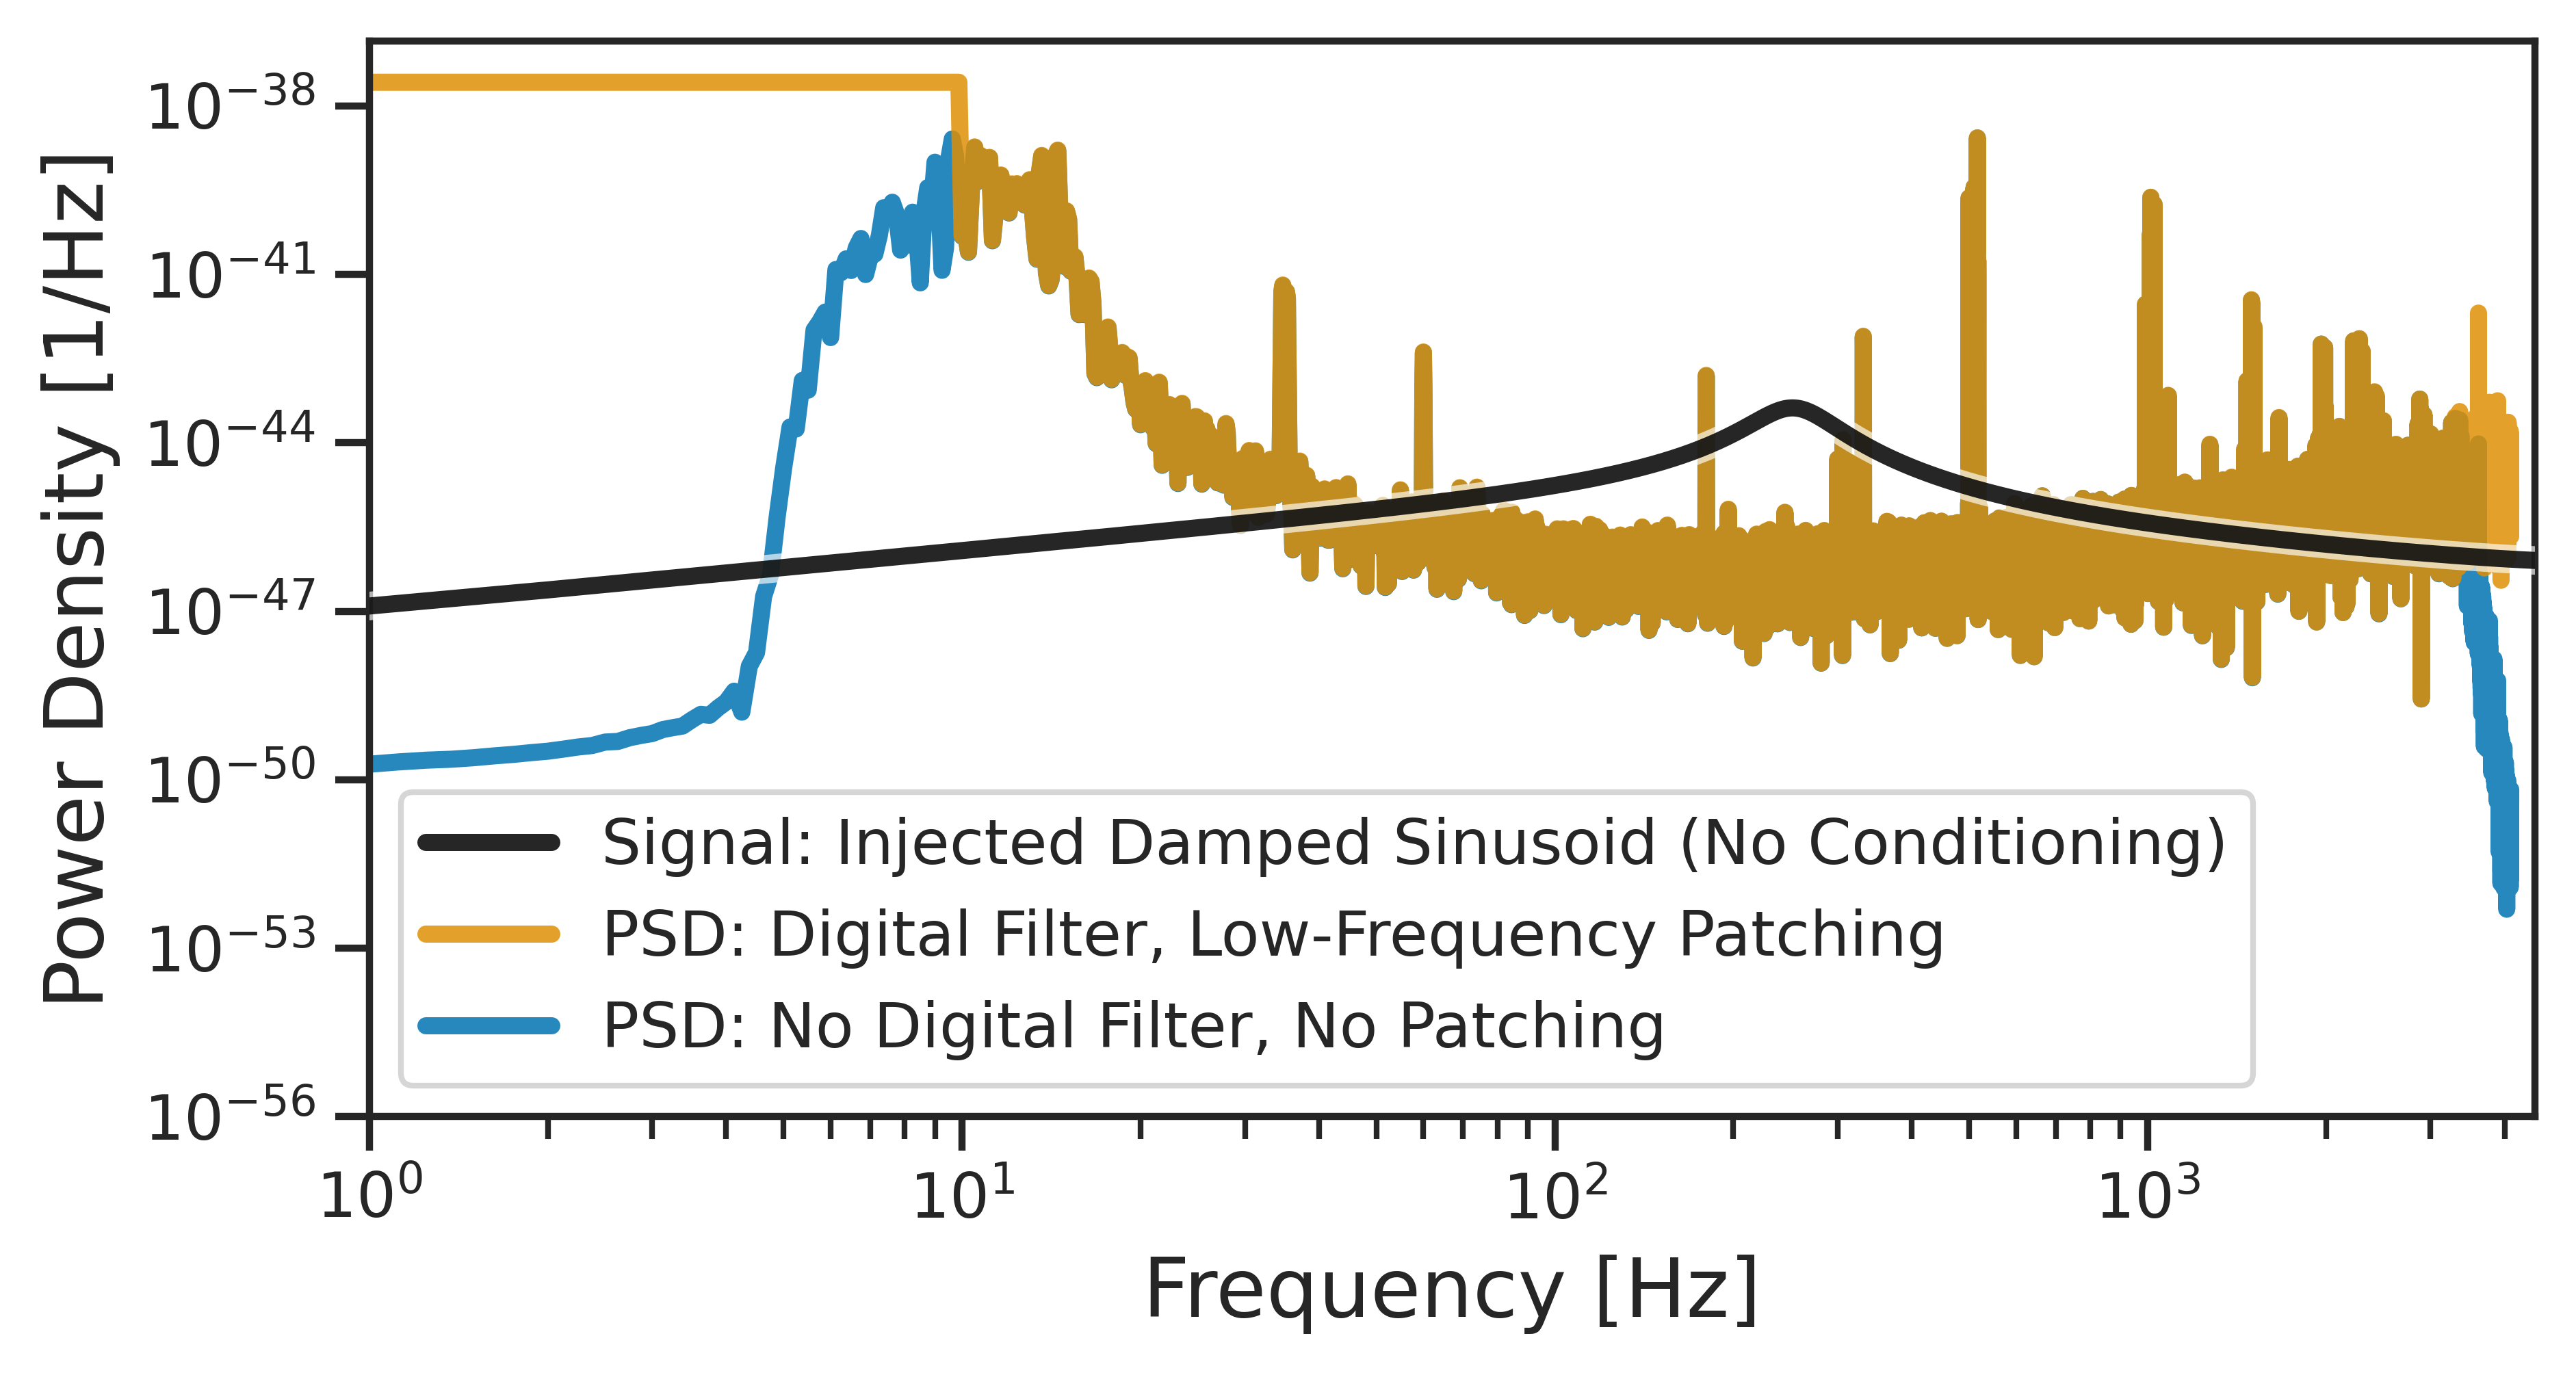

In [434]:
fig, ax = plt.subplots(1,1,figsize=[figsize_square[0],figsize_square[1]/2],dpi=300)

#t0 = 1242442967.4085817 # GW190521
t0 = 1126259462.423 # GW150914
ra = 5.749613171792332
dec = -0.4237903906862163
psi = 1.222853265910277
T = 0.4
ds=2
slice_dur = 256
alpha = 0.85

A = 3e-21 
f_qnm = 250.0
tau_qnm = 0.004
phase_qnm = 5.34 
dur = 0.5

lw = 3

cmap = sns.color_palette("colorblind")

noise_td = generate_noise()
times = noise_td.index

signal = damped_sinusoid(A=A, f=f_qnm, gamma=1/tau_qnm, phase=phase_qnm, times=times[int(len(times)/2):])

signal_FT = np.fft.rfft(signal[64:64+dur].values)/(2**14)*2 #we multiply by 2 to account for throwing out half of the frequencies due to rfft, 
                                                                #in order to get the total power correct
    
delta_t = 1/2**14
freqs_analysis = np.fft.rfftfreq(len(noise_td[64:64+dur]), delta_t)

sig_power = ringdown.FrequencySeries(freqs_analysis*(signal_FT.real**2+signal_FT.imag**2),freqs_analysis)

plt.loglog(sig_power, color = "black", alpha = alpha,zorder = 10, label="Signal: Injected Damped Sinusoid (No Conditioning)",lw=lw,path_effects=[patheff.Stroke(linewidth=5, foreground='w',alpha=0.65), patheff.Normal()])

#Patching, digital filter
fit = ringdown.Fit(model="mchi")
fit.load_data({"L1":"/mnt/home/hsiegel/ceph/database_rd/GW150914_095045/L-L1_GWOSC_16KHZ_R1-1126259447-32.hdf5"},kind="GWOSC")
fit.set_target(t0=t0, ra=ra, dec=dec, psi=psi, duration=T)
fit.condition_data(flow=1/0.1,ds=ds,digital_filter=True,slice_left=slice_dur,slice_right=slice_dur)
nperseg = np2(16*fit.duration*(2**14)/ds)
fit.compute_acfs(method='fd', nperseg=nperseg,flow=1/0.1) # flattened PSD
psd_digfilt = fit.acfs["L1"].to_psd()
plt.loglog(psd_digfilt,alpha=alpha, color = cmap[1], label = "PSD: Digital Filter, Low-Frequency Patching",lw=lw,zorder=0)

#No patch, no digital filter
fit = ringdown.Fit(model="mchi")
fit.load_data({"L1":"/mnt/home/hsiegel/ceph/database_rd/GW150914_095045/L-L1_GWOSC_16KHZ_R1-1126259447-32.hdf5"},kind="GWOSC")
fit.set_target(t0=t0, ra=ra, dec=dec, psi=psi, duration=T)
fit.condition_data(flow=1/0.1,ds=ds,digital_filter=False,slice_left=slice_dur,slice_right=slice_dur)
nperseg = np2(16*fit.duration*(2**14)/ds)
fit.compute_acfs(method='fd', nperseg=nperseg) # flattened PSD
psd = fit.acfs["L1"].to_psd()
plt.loglog(psd,alpha=alpha, color = cmap[0], label = "PSD: No Digital Filter, No Patching",lw=lw,zorder=-5)

#signal2 = ringdown.Data(signal).condition(t0=64,flow=10,fhigh=2**14/(2*2),ds=2)

#signal_FT2 = np.fft.rfft(signal2[64:64+dur].values)/(2**14)*2 #we multiply by 2 to account for throwing out half of the frequencies due to rfft, 
                                                                #in order to get the total power correct
    
#delta_t = 1/2**14
#freqs_analysis = np.fft.rfftfreq(len(noise_td[64:64+dur]), delta_t)

#sig_power2 = ringdown.FrequencySeries(freqs_analysis[::2]*(signal_FT2.real**2+signal_FT2.imag**2),freqs_analysis[0:int(len(freqs_analysis)/2)+1])

#plt.plot(sig_power2, color = "grey", alpha = alpha,zorder = 10, label="Signal: Injected Damped Sinusoid (Filtered)",lw=lw,path_effects=[patheff.Stroke(linewidth=5, foreground='w',alpha=0.65), patheff.Normal()])

ax.set_xlabel('Frequency [Hz]', fontsize = fs_label)
ax.set_ylabel("Power Density [1/Hz]", fontsize = fs_label)

ax.set_xlim(1,2**14/(2*ds)*1.1)
ax.set_ylim(1e-56,ax.get_ylim()[1])

plt.legend()
plt.savefig("/mnt/home/hsiegel/ceph/conditioning_data_studies/figures/GW150914_PSD",bbox_inches="tight")

## Downsampling

GW150914_NOnoise_LIGOWelchPSDAnalogFilter_fundamental_ds1_dur0p05s_flow20p0_A14p5e-21_f1251.00199551019213_ph15p34_tau10p004126712034976184_A25p999999999999999e-21_f2245.42368760857954_ph21p79_tau20p0013647824422501954.nc
GW150914_NOnoise_LIGOWelchPSDAnalogFilter_fundamental_ds4_dur0p05s_flow20p0_A14p5e-21_f1251.00199551019213_ph15p34_tau10p004126712034976184_A25p999999999999999e-21_f2245.42368760857954_ph21p79_tau20p0013647824422501954.nc
GW150914_NOnoise_LIGOWelchPSDAnalogFilter_fundamental_ds8_dur0p05s_flow20p0_A14p5e-21_f1251.00199551019213_ph15p34_tau10p004126712034976184_A25p999999999999999e-21_f2245.42368760857954_ph21p79_tau20p0013647824422501954.nc
GW150914_NOnoise_LIGOWelchPSDAnalogFilter_fundamental_ds16_dur0p05s_flow20p0_A14p5e-21_f1251.00199551019213_ph15p34_tau10p004126712034976184_A25p999999999999999e-21_f2245.42368760857954_ph21p79_tau20p0013647824422501954.nc
GW150914_NOnoise_LIGOWelchPSDAnalogFilter_fundamental_ds32_dur0p05s_flow20p0_A14p5e-21_f1251.00199551019213_ph1

Text(0.5, 0, 'A_220')

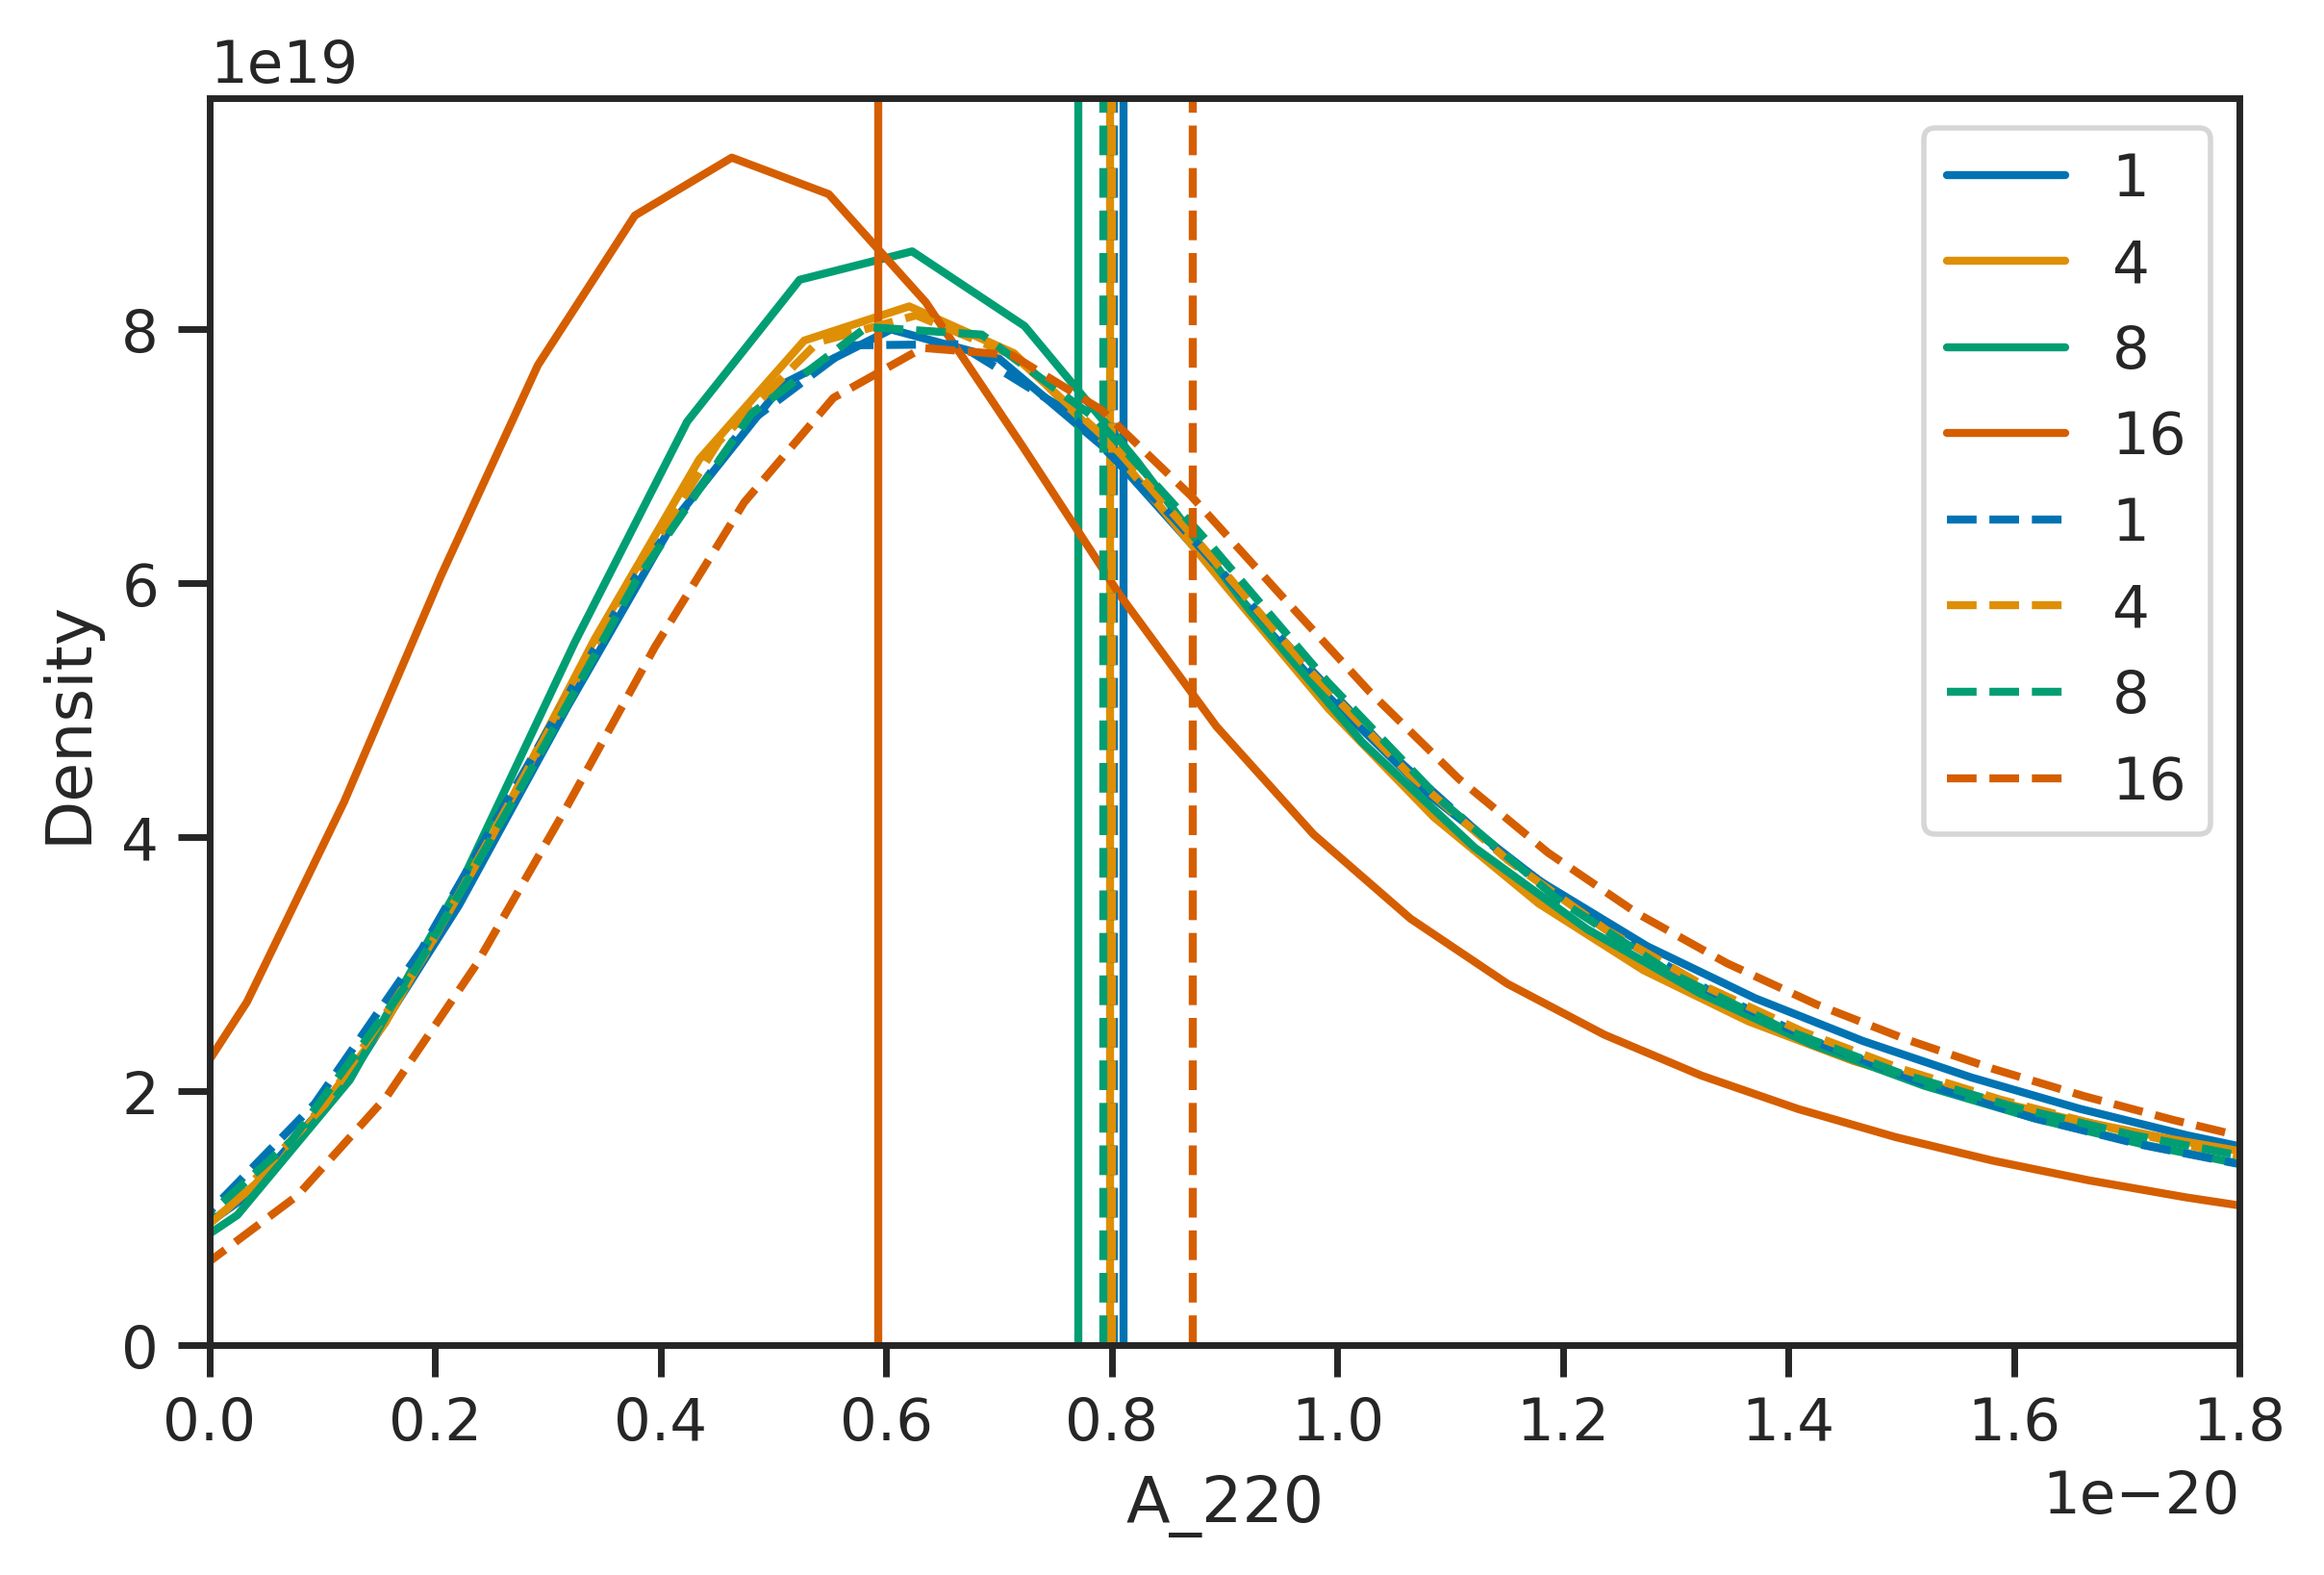

In [326]:
#Load results

results_dir = "/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/"
results_dict = {}
acfs_dict = {}

id_str = "WelchPSDDigital" # identify runs of interest


for f in [x for x in sorted([y for y in os.listdir(results_dir) if ".csv" not in y and ".nc" in y and "A14" in y and "TGR" not in y and "Analog" in y],key = lambda x: int(x.split("ds")[1].split("_")[0]))]:
    print(f)
    results_dict[int(f.split("ds")[1].split("_")[0])] = az.from_netcdf(results_dir + f)
    
c_map = sns.color_palette("colorblind")
cnt = 0
for k,v in results_dict.items():
    if k>16:
        continue
    #sns.histplot(v.result.posterior.df.sel(df_dim_0 = 1).values.flatten(),label=k,fill=False,element="step")
    sns.kdeplot(v.posterior.a.sel(mode=b'1,-2,2,2,0').values.flatten(),label=k,color=c_map[cnt])
    plt.axvline(np.median(v.posterior.a.sel(mode=b'1,-2,2,2,0').values.flatten()),color=c_map[cnt])
    cnt+=1
plt.legend()
#plt.xlim(0,2*4.5e-21)


for f in [x for x in sorted([y for y in os.listdir(results_dir) if ".csv" not in y and ".nc" in y and "A14" in y and "TGR" not in y and "Digital" in y],key = lambda x: int(x.split("ds")[1].split("_")[0]))]:
    print(f)
    results_dict[int(f.split("ds")[1].split("_")[0])] = az.from_netcdf(results_dir + f)
    
c_map = sns.color_palette("colorblind")
cnt = 0
for k,v in results_dict.items():
    if k>16:
        continue
    #sns.histplot(v.result.posterior.df.sel(df_dim_0 = 1).values.flatten(),label=k,fill=False,element="step")
    sns.kdeplot(v.posterior.a.sel(mode=b'1,-2,2,2,0').values.flatten(),label=k,color=c_map[cnt],ls="--")
    plt.axvline(np.median(v.posterior.a.sel(mode=b'1,-2,2,2,0').values.flatten()),ls="--",color=c_map[cnt])
    cnt+=1
plt.legend()

plt.xlim(0,4*4.5e-21)

plt.xlabel("A_220")


(0.0, 9e-21)

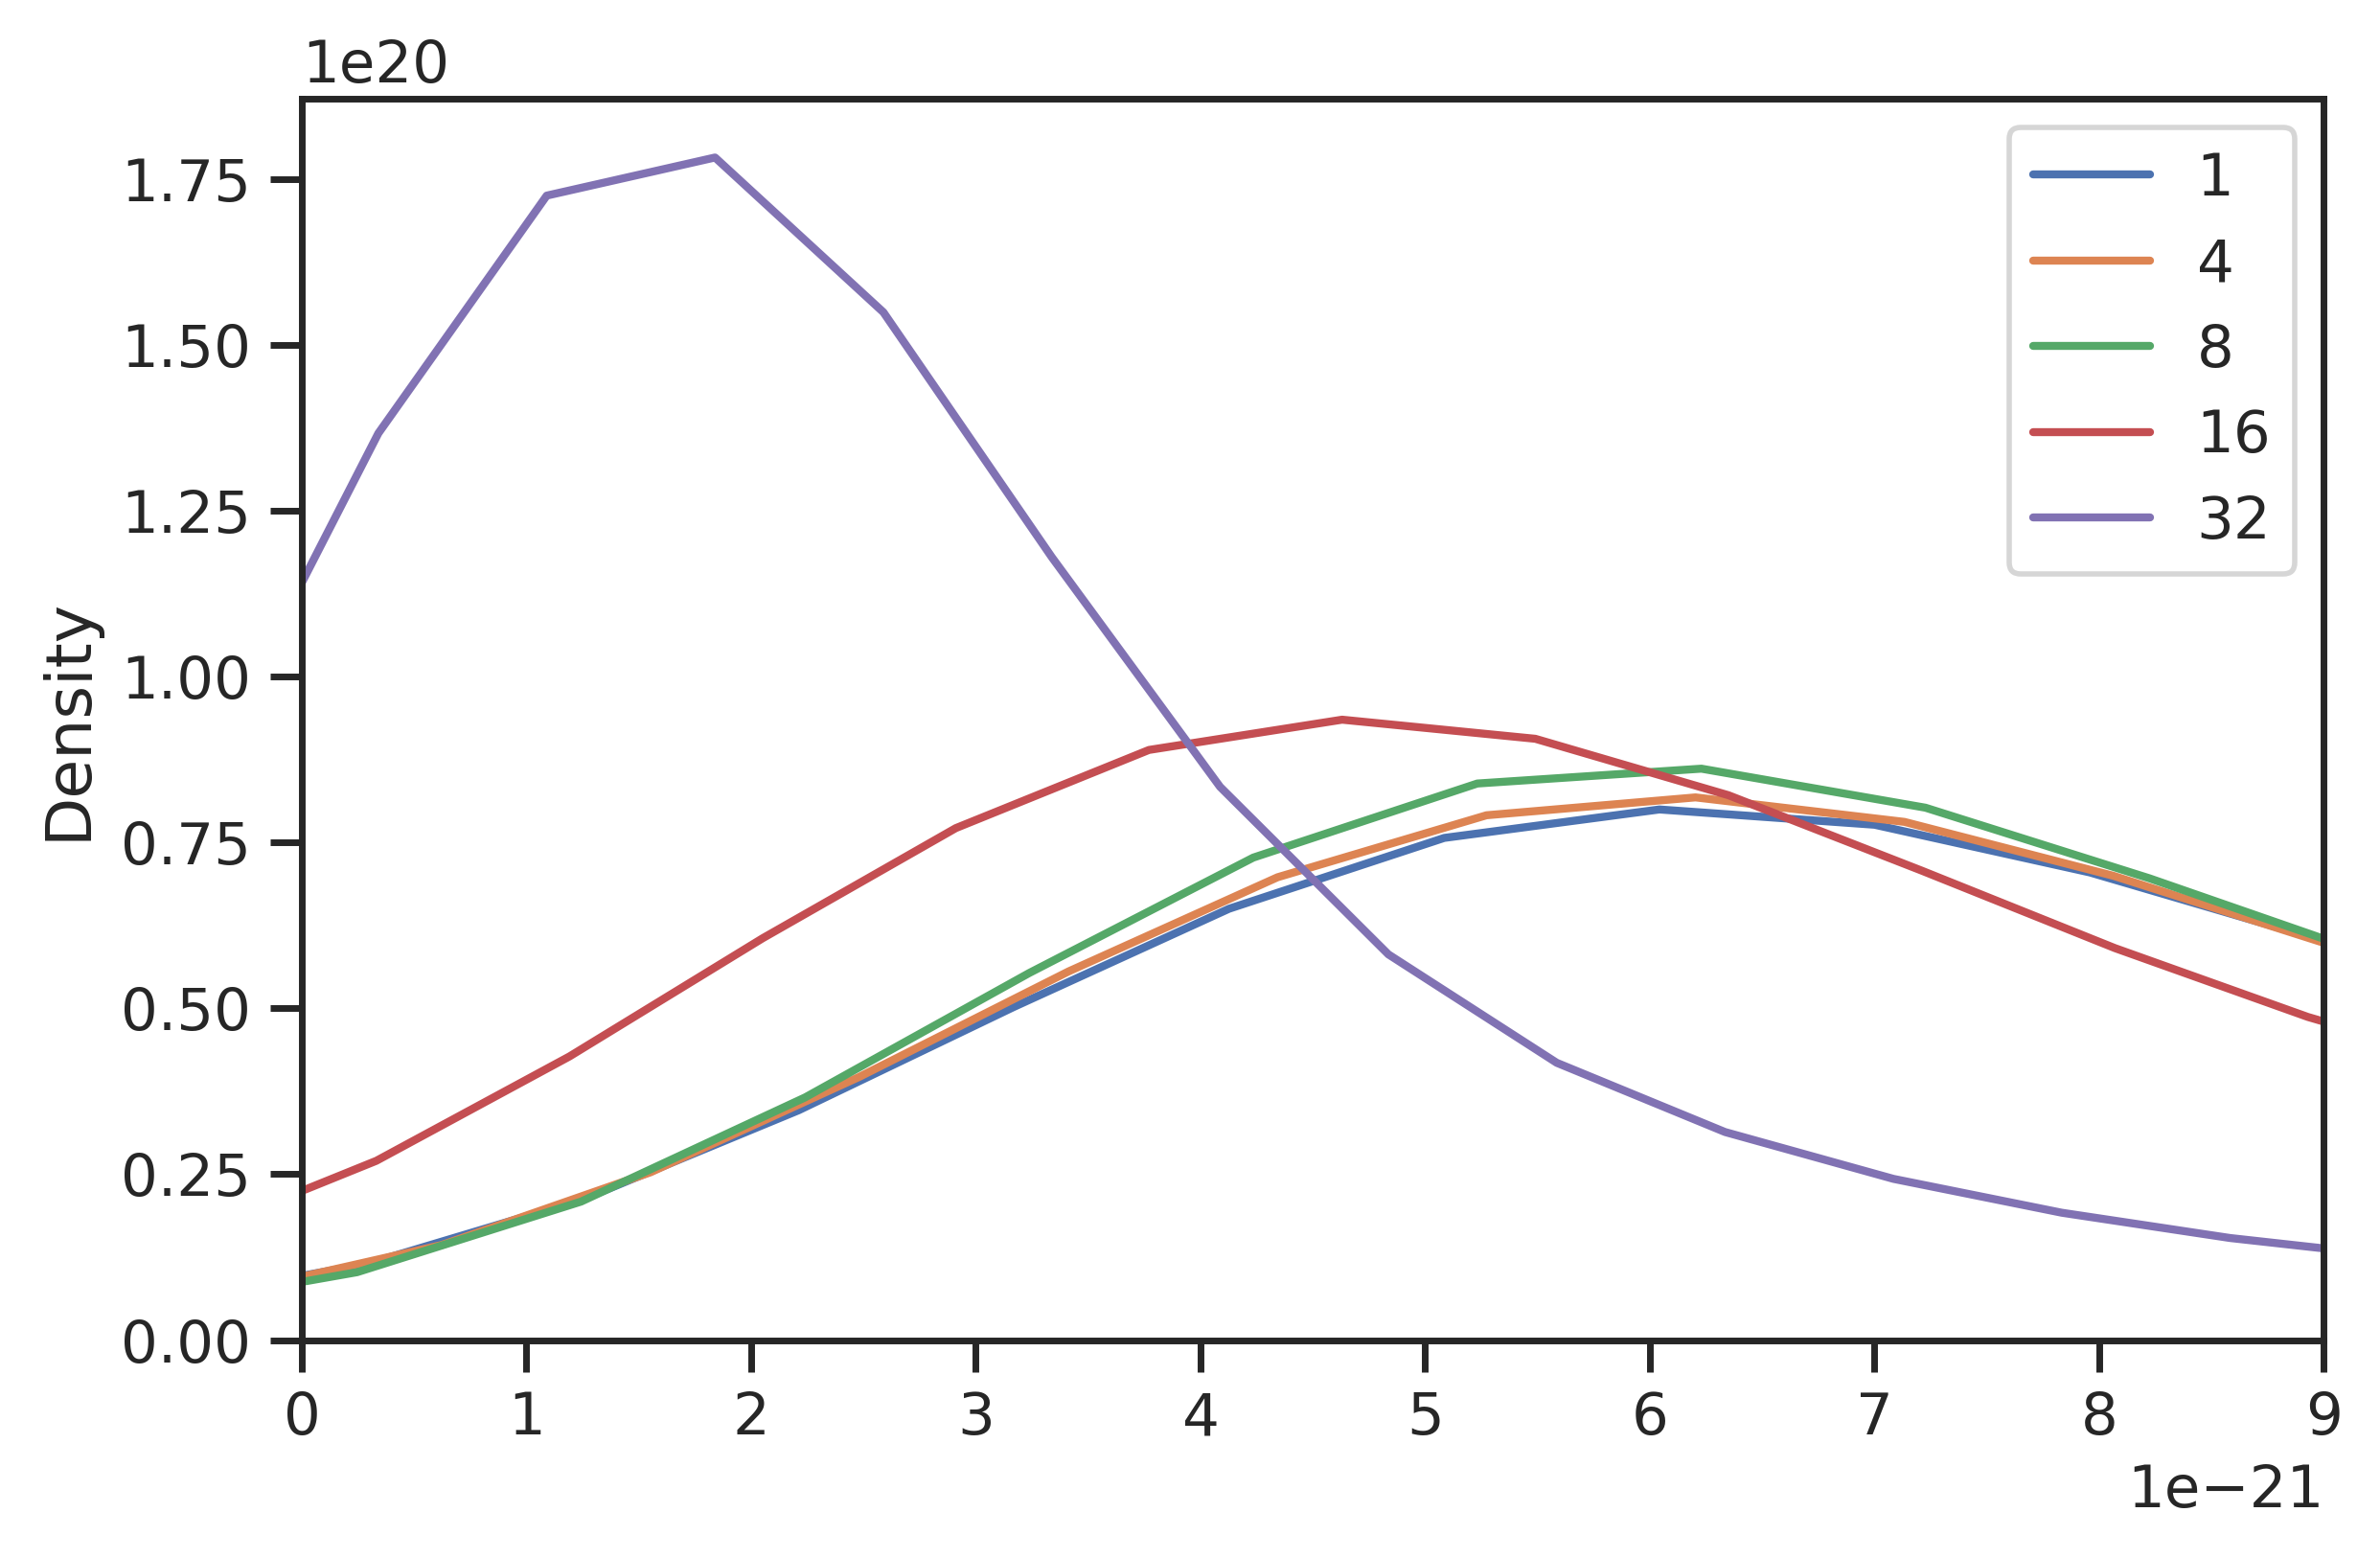

In [305]:
c_map = sns.color_palette("colorblind")
cnt = 0
for k,v in results_dict.items():
    #sns.histplot(v.result.posterior.df.sel(df_dim_0 = 1).values.flatten(),label=k,fill=False,element="step")
    sns.kdeplot(v.posterior.a.sel(mode=b'1,-2,2,2,0').values.flatten(),label=k)
    cnt+=1
plt.legend()
plt.xlim(0,2*4.5e-21)

In [306]:
#Load results

results_dir = "/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/"
results_dict = {}
acfs_dict = {}

id_str = "WelchPSDDigital" # identify runs of interest


for f in [x for x in sorted([y for y in os.listdir(results_dir) if ".csv" not in y and ".nc" in y and "A14" in y and "TGR" not in y and "Digital" in y],key = lambda x: int(x.split("ds")[1].split("_")[0]))]:
    print(f)
    results_dict[int(f.split("ds")[1].split("_")[0])] = az.from_netcdf(results_dir + f)


GW150914_NOnoise_LIGOWelchPSDDigitalFilter_fundamental_ds1_dur0p05s_flow20p0_A14p5e-21_f1251.00199551019213_ph15p34_tau10p004126712034976184_A25p999999999999999e-21_f2245.42368760857954_ph21p79_tau20p0013647824422501954.nc
GW150914_NOnoise_LIGOWelchPSDDigitalFilter_fundamental_ds4_dur0p05s_flow20p0_A14p5e-21_f1251.00199551019213_ph15p34_tau10p004126712034976184_A25p999999999999999e-21_f2245.42368760857954_ph21p79_tau20p0013647824422501954.nc
GW150914_NOnoise_LIGOWelchPSDDigitalFilter_fundamental_ds8_dur0p05s_flow20p0_A14p5e-21_f1251.00199551019213_ph15p34_tau10p004126712034976184_A25p999999999999999e-21_f2245.42368760857954_ph21p79_tau20p0013647824422501954.nc
GW150914_NOnoise_LIGOWelchPSDDigitalFilter_fundamental_ds16_dur0p05s_flow20p0_A14p5e-21_f1251.00199551019213_ph15p34_tau10p004126712034976184_A25p999999999999999e-21_f2245.42368760857954_ph21p79_tau20p0013647824422501954.nc
GW150914_NOnoise_LIGOWelchPSDDigitalFilter_fundamental_ds32_dur0p05s_flow20p0_A14p5e-21_f1251.0019955101921

(0.0, 9e-21)

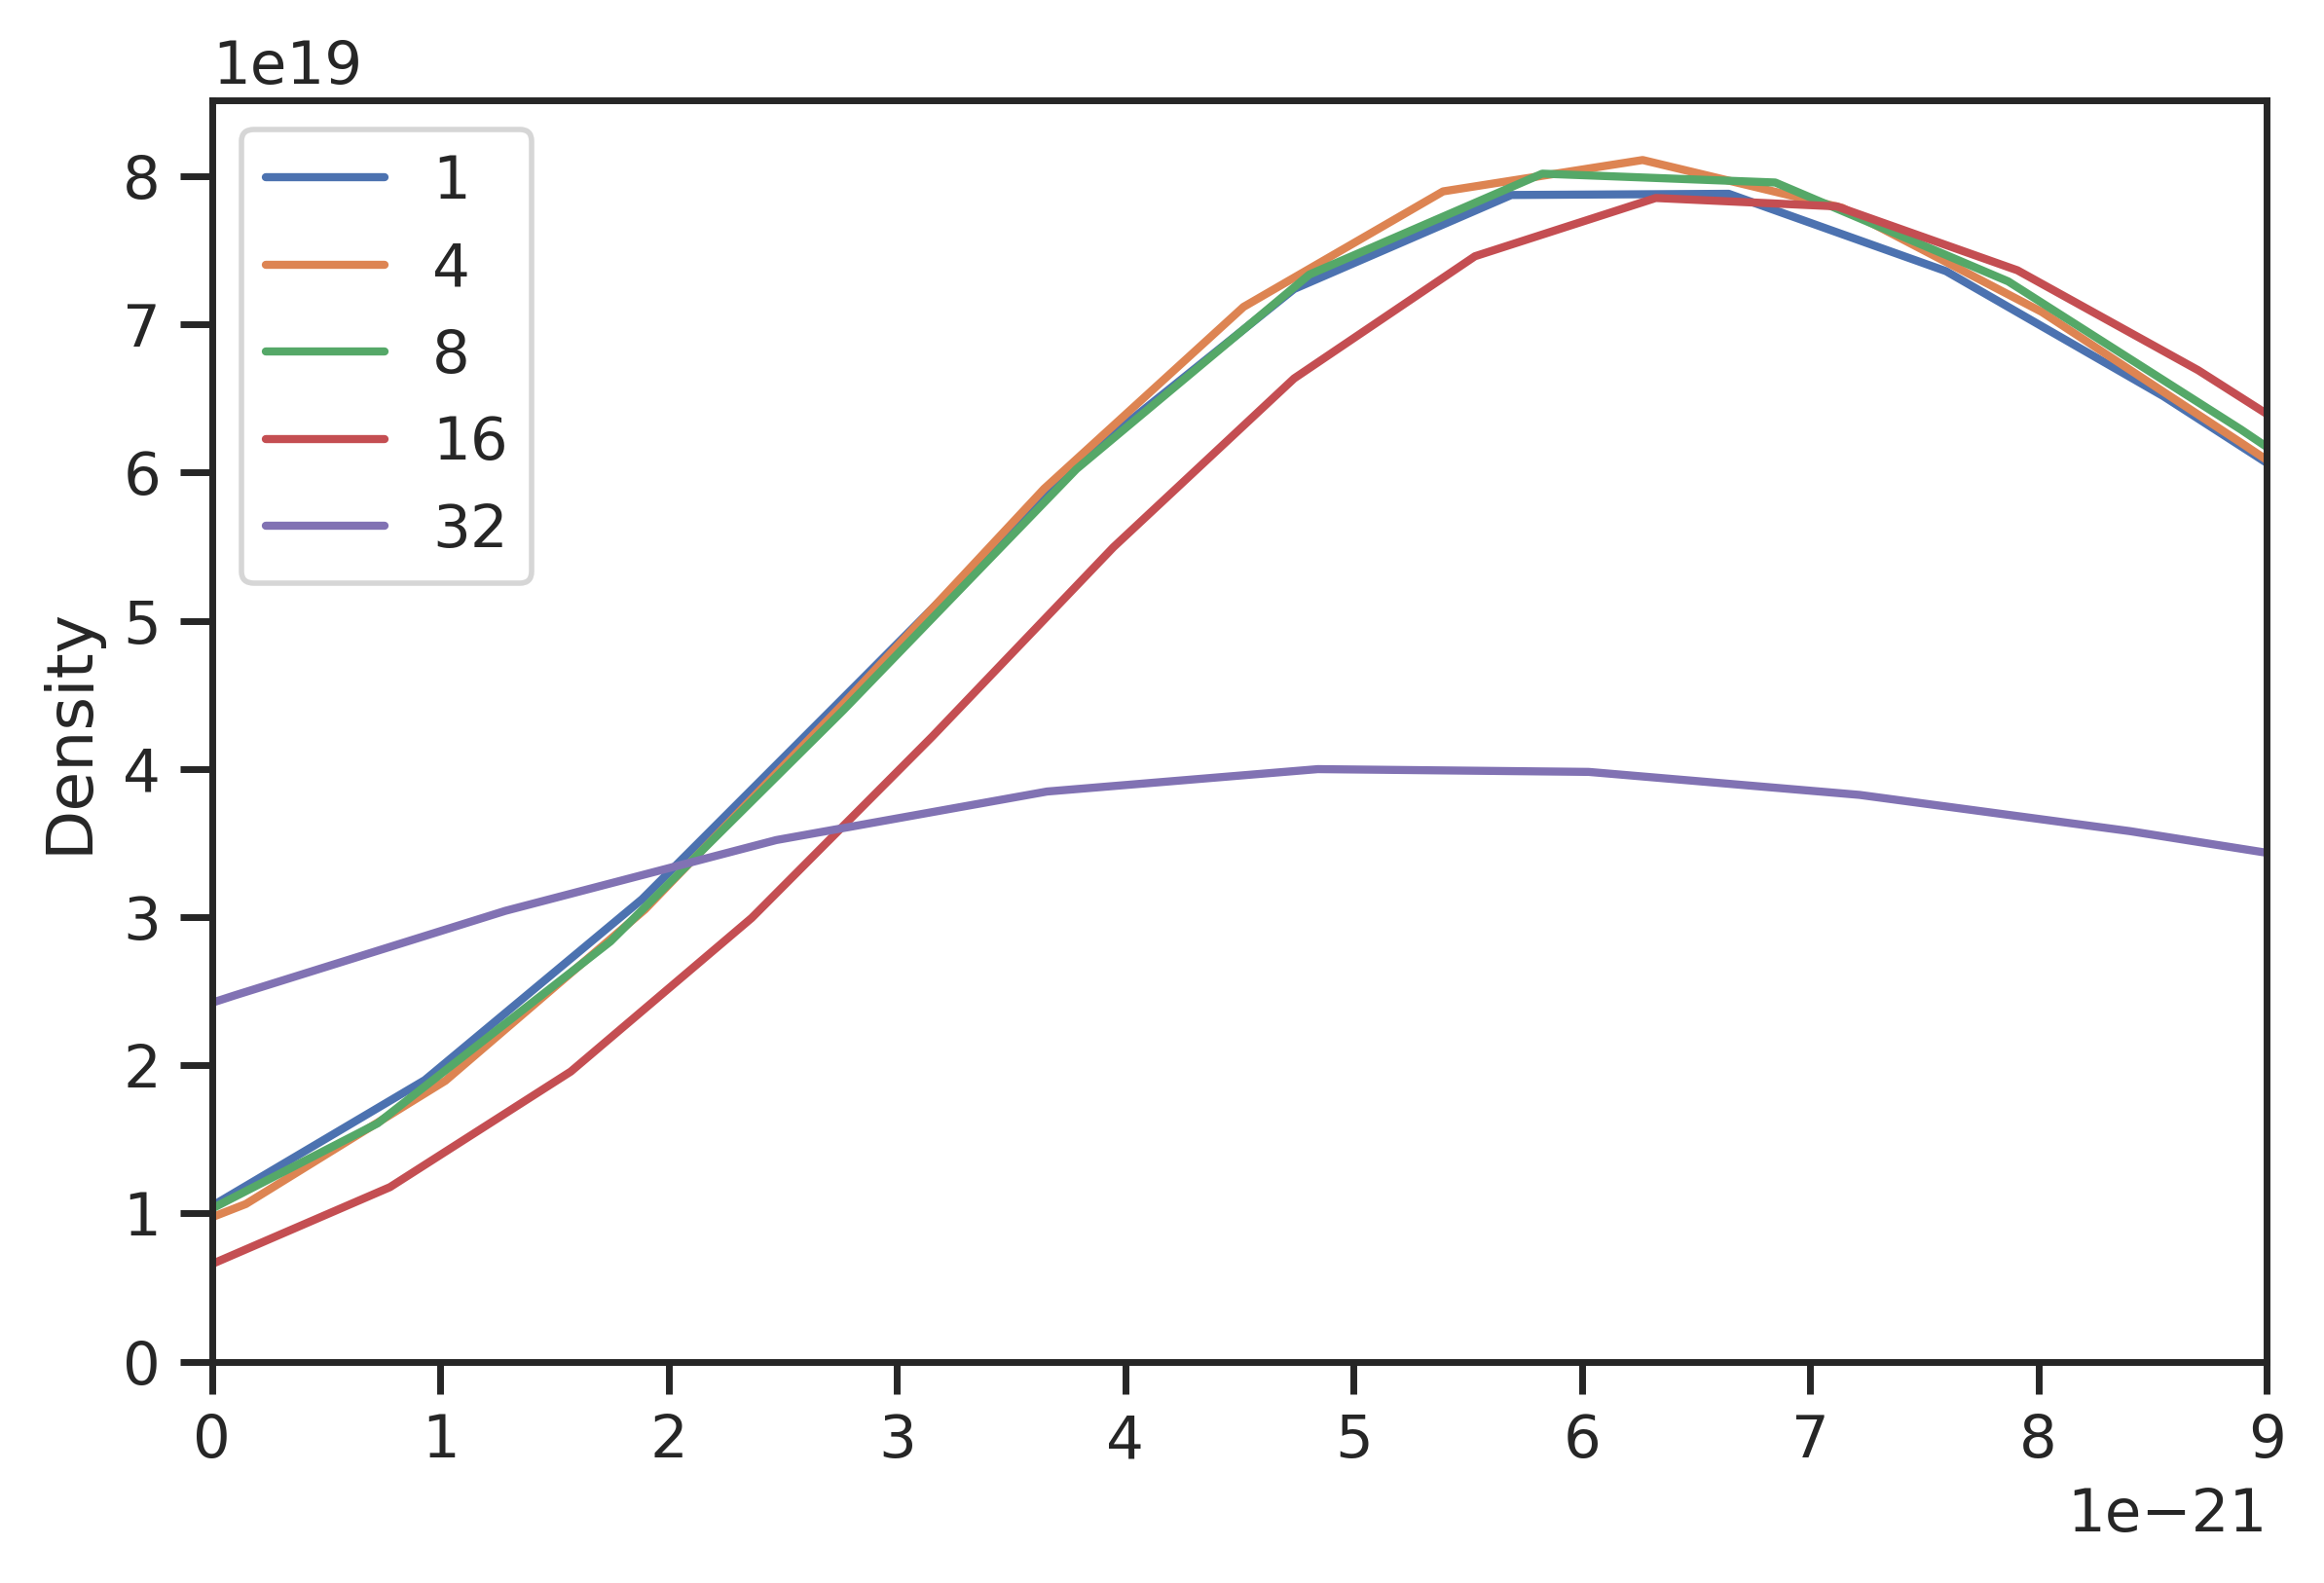

In [307]:
c_map = sns.color_palette("colorblind")
cnt = 0
for k,v in results_dict.items():
    #sns.histplot(v.result.posterior.df.sel(df_dim_0 = 1).values.flatten(),label=k,fill=False,element="step")
    sns.kdeplot(v.posterior.a.sel(mode=b'1,-2,2,2,0').values.flatten(),label=k)
    cnt+=1
plt.legend()
plt.xlim(0,2*4.5e-21)

### No noise

In [291]:
#Load results

results_dir = "/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/"
results_dict = {}
acfs_dict = {}

id_str = "WelchPSDDigital" # identify runs of interest


for f in [x for x in sorted([y for y in os.listdir(results_dir) if ".csv" not in y and ".nc" in y and id_str in y and "TEST" in y and "flow20" in y and "GW150914" in y],key = lambda x: int(x.split("ds")[1].split("_")[0]))]:
    print(f)
    results_dict[int(f.split("ds")[1].split("_")[0])] = az.from_netcdf(results_dir + f)
    
A = float(f.split("A")[-1].split("_")[0].replace("p","."))
f_qnm = float(f.split("f")[-1].split("_")[0].replace("p","."))
tau_qnm = float(f.split("tau")[1].split(".")[0].replace("p","."))
phase_qnm = float(f.split("ph")[1].split("_")[0].replace("p","."))
dur = float(f.split("dur")[1].split("s_")[0].replace("p","."))

for f in [x for x in sorted([y for y in os.listdir(results_dir) if ".csv" in y and ".nc" not in y and id_str in y and "flow20" in y and "2modes" not in y and "GW150914" in y],key = lambda x: int(x.split("ds")[1].split(".")[0]))]:
    print(f)
    acfs_dict[int(f.split("ds")[1].split(".")[0])] = ringdown.AutoCovariance(pd.read_csv(results_dir+f).values.T[1],pd.read_csv(results_dir+f).values.T[0])

print(A,f_qnm,tau_qnm,phase_qnm, dur)

TEST_GW150914_NOnoise_LIGOWelchPSDDigitalFilter_fundamental_ds1_dur0p05s_flow20p0__A3e-21_f250_ph5p34_tau0p004.nc
TEST_GW150914_NOnoise_LIGOWelchPSDDigitalFilter_fundamental_ds4_dur0p05s_flow20p0__A3e-21_f250_ph5p34_tau0p004.nc
TEST_GW150914_NOnoise_LIGOWelchPSDDigitalFilter_fundamental_ds8_dur0p05s_flow20p0__A3e-21_f250_ph5p34_tau0p004.nc
TEST_GW150914_NOnoise_LIGOWelchPSDDigitalFilter_fundamental_ds16_dur0p05s_flow20p0__A3e-21_f250_ph5p34_tau0p004.nc
TEST_GW150914_NOnoise_LIGOWelchPSDDigitalFilter_fundamental_ds32_dur0p05s_flow20p0__A3e-21_f250_ph5p34_tau0p004.nc
ACF_GW150914_NOnoise_LIGOWelchPSDDigitalFilter_fundamental_dur0p05_flow20p0_ds1.csv
ACF_GW150914_NOnoise_LIGOWelchPSDDigitalFilter_fundamental_dur0p05_flow20p0_ds4.csv
ACF_GW150914_NOnoise_LIGOWelchPSDDigitalFilter_fundamental_dur0p05_flow20p0_ds8.csv
ACF_GW150914_NOnoise_LIGOWelchPSDDigitalFilter_fundamental_dur0p05_flow20p0_ds16.csv
ACF_GW150914_NOnoise_LIGOWelchPSDDigitalFilter_fundamental_dur0p05_flow20p0_ds32.csv
3e-21 

In [292]:
#generating things to plot

snrsq_dict = {}

sample_rate = 2**14
t0 = 128/2
noise_td  = generate_noise(lalpsd = True, sr = sample_rate)
times = noise_td.index
signal = damped_sinusoid(A=A, f=f_qnm, gamma=1/tau_qnm, phase=phase_qnm, times=times[int(len(times)/2):])


for ds in results_dict.keys():
    print("ds =",ds)
    acf_analysis = acfs_dict[ds]
    analysis_data = ringdown.Data(signal,noise_td.index)
    analysis_data_cond = analysis_data.condition(t0=t0,ds=ds,digital_filter = True)
    
    whtnd_sig = acf_analysis[0:dur].whiten(signal[t0:t0+dur][::ds])
    whtnd_data = acf_analysis[0:dur].whiten(analysis_data_cond[t0:t0+dur])
        
    ss = np.sum(np.square(whtnd_sig))
    #sd = np.sum(whtnd_sig*whtnd_data)
    #ss = np.sum(np.square(whtnd_data))
    snrsq_dict[ds]=ss

print(snrsq_dict)

psd = acfs_dict[1].to_psd()

signal_FT = np.fft.rfft(signal[t0:t0+dur].values)/sample_rate*2 #we multiply by 2 to account for throwing out half of the frequencies due to rfft, 
                                                                #in order to get the total power correct
    
delta_t = 1/sample_rate
freqs_analysis = np.fft.rfftfreq(len(noise_td[t0:t0+dur]), delta_t)

sig_power = ringdown.FrequencySeries(freqs_analysis*(signal_FT.real**2+signal_FT.imag**2),freqs_analysis)

ds_max = max(results_dict.keys())

ds = 1
ds = 4
ds = 8
ds = 16
ds = 32
{1: 1093.357016111042, 4: 1094.3175074086228, 8: 1089.8653693603799, 16: 1044.9113596448776, 32: 741.0590193515583}


Nyq = 8192.0
Nyq = 2048.0
Nyq = 1024.0
Nyq = 512.0
Nyq = 256.0
1 2.4480872
4 2.3348265
8 2.2193751


/tmp/ipykernel_2300017/3474727187.py:60: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  y = sig_power.iloc()[sig_power.index.get_loc(x,method = "nearest")] * 1.7e1 * y_offset
/tmp/ipykernel_2300017/3474727187.py:60: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  y = sig_power.iloc()[sig_power.index.get_loc(x,method = "nearest")] * 1.7e1 * y_offset
/tmp/ipykernel_2300017/3474727187.py:60: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  y = sig_power.iloc()[sig_power.index.get_loc(x,method = "nearest")] * 1.7e1 * y_offset
/tmp/ipykernel_2300017/3474727187.py:60: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. 

16 225.60799
32 3.6426392


Text(0, 0.5, 'Probability Density')

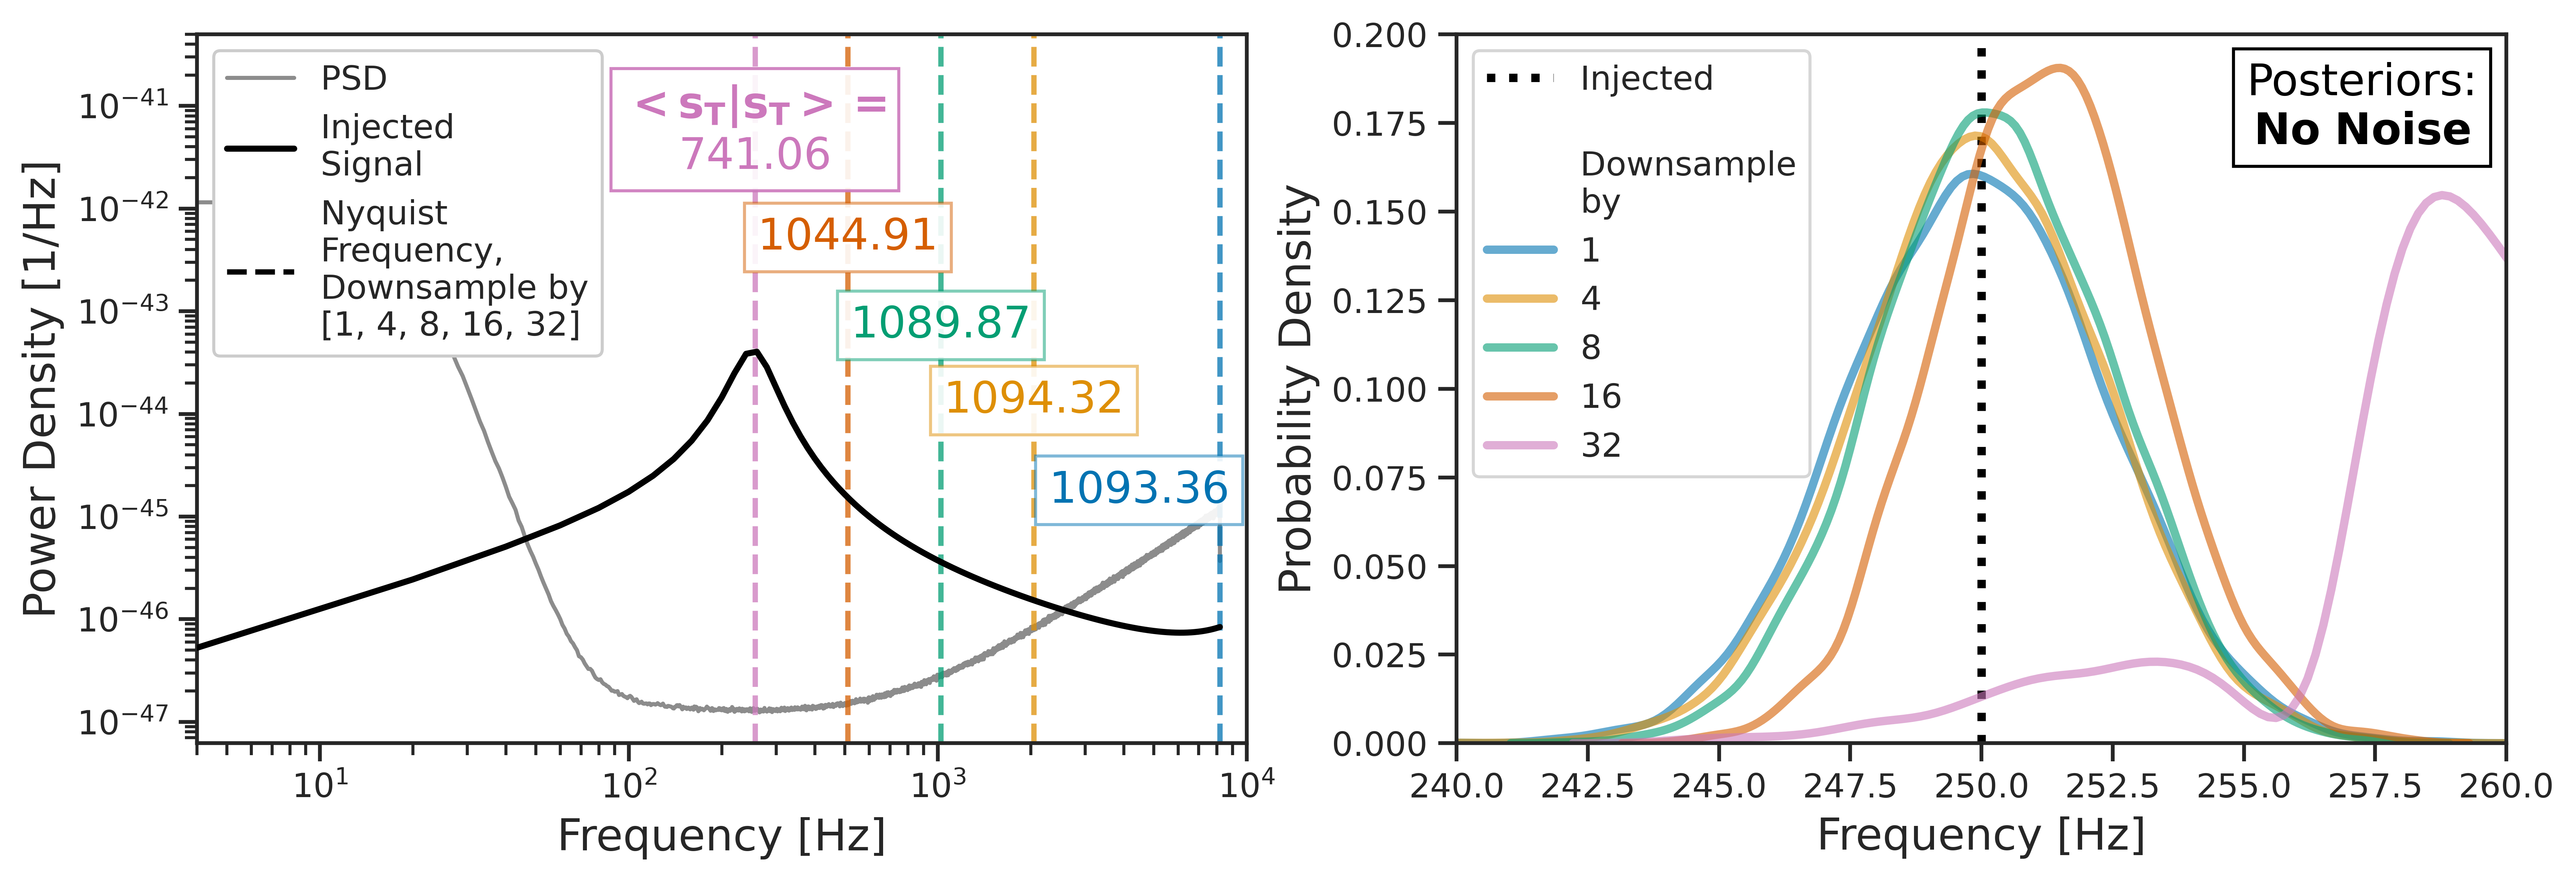

In [293]:
#plotting

fig, ax = plt.subplots(1,2, figsize = (fig_width*2,fig_height), dpi = 300)

cmap = sns.color_palette("colorblind")

small_lw = 2
med_lw = 2.75
big_lw = 3.5

#Plotting for ax[0]
delta_t = 1/sample_rate

ax[0].plot(psd.index, psd.values, label = "PSD", color = "grey", lw = small_lw*2/3, ls = "-", zorder = -100, alpha = 0.9)
        
ax[0].plot(sig_power, color = "black", label="Injected\nSignal", lw=small_lw, zorder = 100)

ax[0].set_ylim(min(psd)*0.5, 5e-41)
ax[0].set_xlim(4,10**4)
ax[0].set_yscale("log")
ax[0].set_xscale("log")
ax[0].set_xlabel('Frequency [Hz]',fontsize = fs_label)
ax[0].set_ylabel("Power Density [1/Hz]", fontsize = fs_label)
    
c_count = 0
lw = 1.75
lst = "--"
alpha = 0.75

#ann_slope = -3.2 #slope for producing straight lines on loglog plot
#b = np.log(5e-47)-ann_slope*np.log(8192) #y intercept for producing straight lines on loglog plot

ds_str = "["
for x in results_dict.keys():
    ds_str+=str(x)+", "
ds_str = ds_str[:-2]+"]"

for k,v in results_dict.items():
    nyq_freq = sample_rate/(2*k)
    print("Nyq =",nyq_freq)
    
    if k == 1:
        ax[0].axvline(0,label = "Nyquist\nFrequency,\nDownsample by\n{}".format(ds_str),lw = lw, ls = lst, color= "black")
        
    if k==24:
        alpha = 0.95
        
    ax[0].axvline(nyq_freq, ls=lst,color=cmap[c_count],lw = lw, alpha = alpha)
        
    if k==1:
        ann_offset_x = -3700
    else:
        ann_offset_x = 0
    
    x=nyq_freq+ann_offset_x
    #y=np.exp(np.log(x)*ann_slope)*np.exp(b) # produce straight lines on a loglog plot
    y_offset = (c_count+1)**2
    if k ==ds_max:
        y_offset = y_offset/7
    y = sig_power.iloc()[sig_power.index.get_loc(x,method = "nearest")] * 1.7e1 * y_offset
    
    if k==ds_max:
        ax[0].annotate(r'$\bf{<s_T|s_T>=}$' + '\n' + '{:.2f}'.format(snrsq_dict[k]),xy=[x,y],fontsize=fs_label, color=cmap[c_count],ha="center", bbox=dict(fc=clrs.to_rgba("white")[:-1] + (0.9,),ec=clrs.to_rgba(cmap[c_count])[:-1]+(0.9,),boxstyle="square"),zorder = -k+100)
    else:
        ax[0].annotate("{:.2f}".format(snrsq_dict[k]),xy=[x,y],fontsize=fs_label, color=cmap[c_count],ha="center", bbox=dict(fc=clrs.to_rgba("white")[:-1] + (0.9,),ec=clrs.to_rgba(cmap[c_count])[:-1]+(0.5,) ,boxstyle="square"),zorder = -k+100)
    c_count +=1

ax[0].legend(loc="upper left",framealpha=1)

    
#Plotting for ax[1]

kde_dict = {}
ax[1].axvline(250, ls = ":", zorder = -10, color="black", label = "Injected",lw=med_lw)
ax[1].axvline(250, zorder = -10, lw=0, color=None, label = "\nDownsample\nby")
alpha = 0.6
c_count = 0
#lw = small_lw
lw = med_lw
for k,v in results_dict.items():
    chain_max = 4
    if k == 16:
        chain_max = 3
    sns.kdeplot(v.posterior.f[0:chain_max].values.flatten(),label = k, linewidth=lw, alpha = alpha, ax = ax[1],color=cmap[c_count])
    print(k, np.std(v.posterior.f.values.flatten()))
    c_count +=1
        
ax[1].set_xlim(f_qnm-10,f_qnm+10)
ann_box_offset_x = 0.8625
ann_box_offset_y = 0.845
ax[1].annotate("Posteriors:\n" + r'$\bf{No~Noise}$', xy=[ax[1].get_xlim()[0]+(ax[1].get_xlim()[1]-ax[1].get_xlim()[0])*ann_box_offset_x, ax[1].get_ylim()[0]+(ax[1].get_ylim()[1]-ax[1].get_ylim()[0])*ann_box_offset_y], color="black", fontsize = fs_label, ha = "center", bbox=dict(boxstyle="square", fc = "white", ec="black"))
ax[1].legend(loc = "upper left")
ax[1].set_xlabel('Frequency [Hz]',fontsize = fs_label)
ax[1].set_ylabel("Probability Density",fontsize = fs_label)

#plt.savefig("/mnt/home/hsiegel/ceph/conditioning_data_studies/figures/downsample_bias_NOnoise",bbox_inches="tight")

#### TGR

In [140]:
#Load results

results_dir = "/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/"
results_dict = {}
acfs_dict = {}

id_str = "TGR" # identify runs of interest

for f in [x for x in sorted([y for y in os.listdir(results_dir) if ".csv" not in y and ".nc" in y and id_str in y and "flow20" in y and "A14" in y and "GW150914" in y],key = lambda x: int(x.split("ds")[1].split("_")[0]))]:
    print(f)
    results_dict[int(f.split("ds")[1].split("_")[0])] = az.from_netcdf(results_dir + f)

A = [float(f.split("A1")[-1].split("_")[0].replace("p","."))]
f_qnm = [float(f.split("f1")[-1].split("_")[0].replace("p","."))]
tau_qnm = [float(f.split("tau1")[-1].split("_")[0].replace("p","."))]
phase_qnm = [float(f.split("ph1")[-1].split("_")[0].replace("p","."))]

A.append(float(f.split("A2")[-1].split("_")[0].replace("p",".")))
f_qnm.append(float(f.split("f2")[-1].split("_")[0].replace("p",".")))
tau_qnm.append(float(f.split("tau2")[-1].split(".")[0].replace("p",".")))
phase_qnm.append(float(f.split("ph2")[-1].split("_")[0].replace("p",".")))

dur = float(f.split("dur")[1].split("s_")[0].replace("p","."))

for f in [x for x in sorted([y for y in os.listdir(results_dir) if ".csv" in y and ".nc" not in y and id_str in y and "flow20" in y and "2modes" in y and "GW150914" in y],key = lambda x: int(x.split("ds")[1].split(".")[0]))]:
    print(f)
    acfs_dict[int(f.split("ds")[1].split(".")[0])] = ringdown.AutoCovariance(pd.read_csv(results_dir+f).values.T[1],pd.read_csv(results_dir+f).values.T[0])

print(A,f_qnm,tau_qnm,phase_qnm,dur)

TGR_GW150914_NOnoise_LIGOWelchPSDDigitalFilter_fundamental_ds1_dur0p05s_flow20p0_A14p5e-21_f1251.00199551019213_ph15p34_tau10p004126712034976184_A25p999999999999999e-21_f2245.42368760857954_ph21p79_tau20p0013647824422501954.nc
TGR_GW150914_NOnoise_LIGOWelchPSDDigitalFilter_fundamental_ds4_dur0p05s_flow20p0_A14p5e-21_f1251.00199551019213_ph15p34_tau10p004126712034976184_A25p999999999999999e-21_f2245.42368760857954_ph21p79_tau20p0013647824422501954.nc
TGR_GW150914_NOnoise_LIGOWelchPSDDigitalFilter_fundamental_ds8_dur0p05s_flow20p0_A14p5e-21_f1251.00199551019213_ph15p34_tau10p004126712034976184_A25p999999999999999e-21_f2245.42368760857954_ph21p79_tau20p0013647824422501954.nc
TGR_GW150914_NOnoise_LIGOWelchPSDDigitalFilter_fundamental_ds16_dur0p05s_flow20p0_A14p5e-21_f1251.00199551019213_ph15p34_tau10p004126712034976184_A25p999999999999999e-21_f2245.42368760857954_ph21p79_tau20p0013647824422501954.nc
TGR_GW150914_NOnoise_LIGOWelchPSDDigitalFilter_fundamental_ds32_dur0p05s_flow20p0_A14p5e-21

In [141]:
sample_rate = 2**14
t0 = 128/2
noise_td  = generate_noise(lalpsd = True, sr = sample_rate)
times = noise_td.index

signal1 = damped_sinusoid(A=A[0], f=f_qnm[0], gamma=1/tau_qnm[0], phase=phase_qnm[0], times=times[int(len(times)/2):])
signal2 = damped_sinusoid(A=A[1], f=f_qnm[1], gamma=1/tau_qnm[1], phase=phase_qnm[1], times=times[int(len(times)/2):])

signal = signal1 + signal2

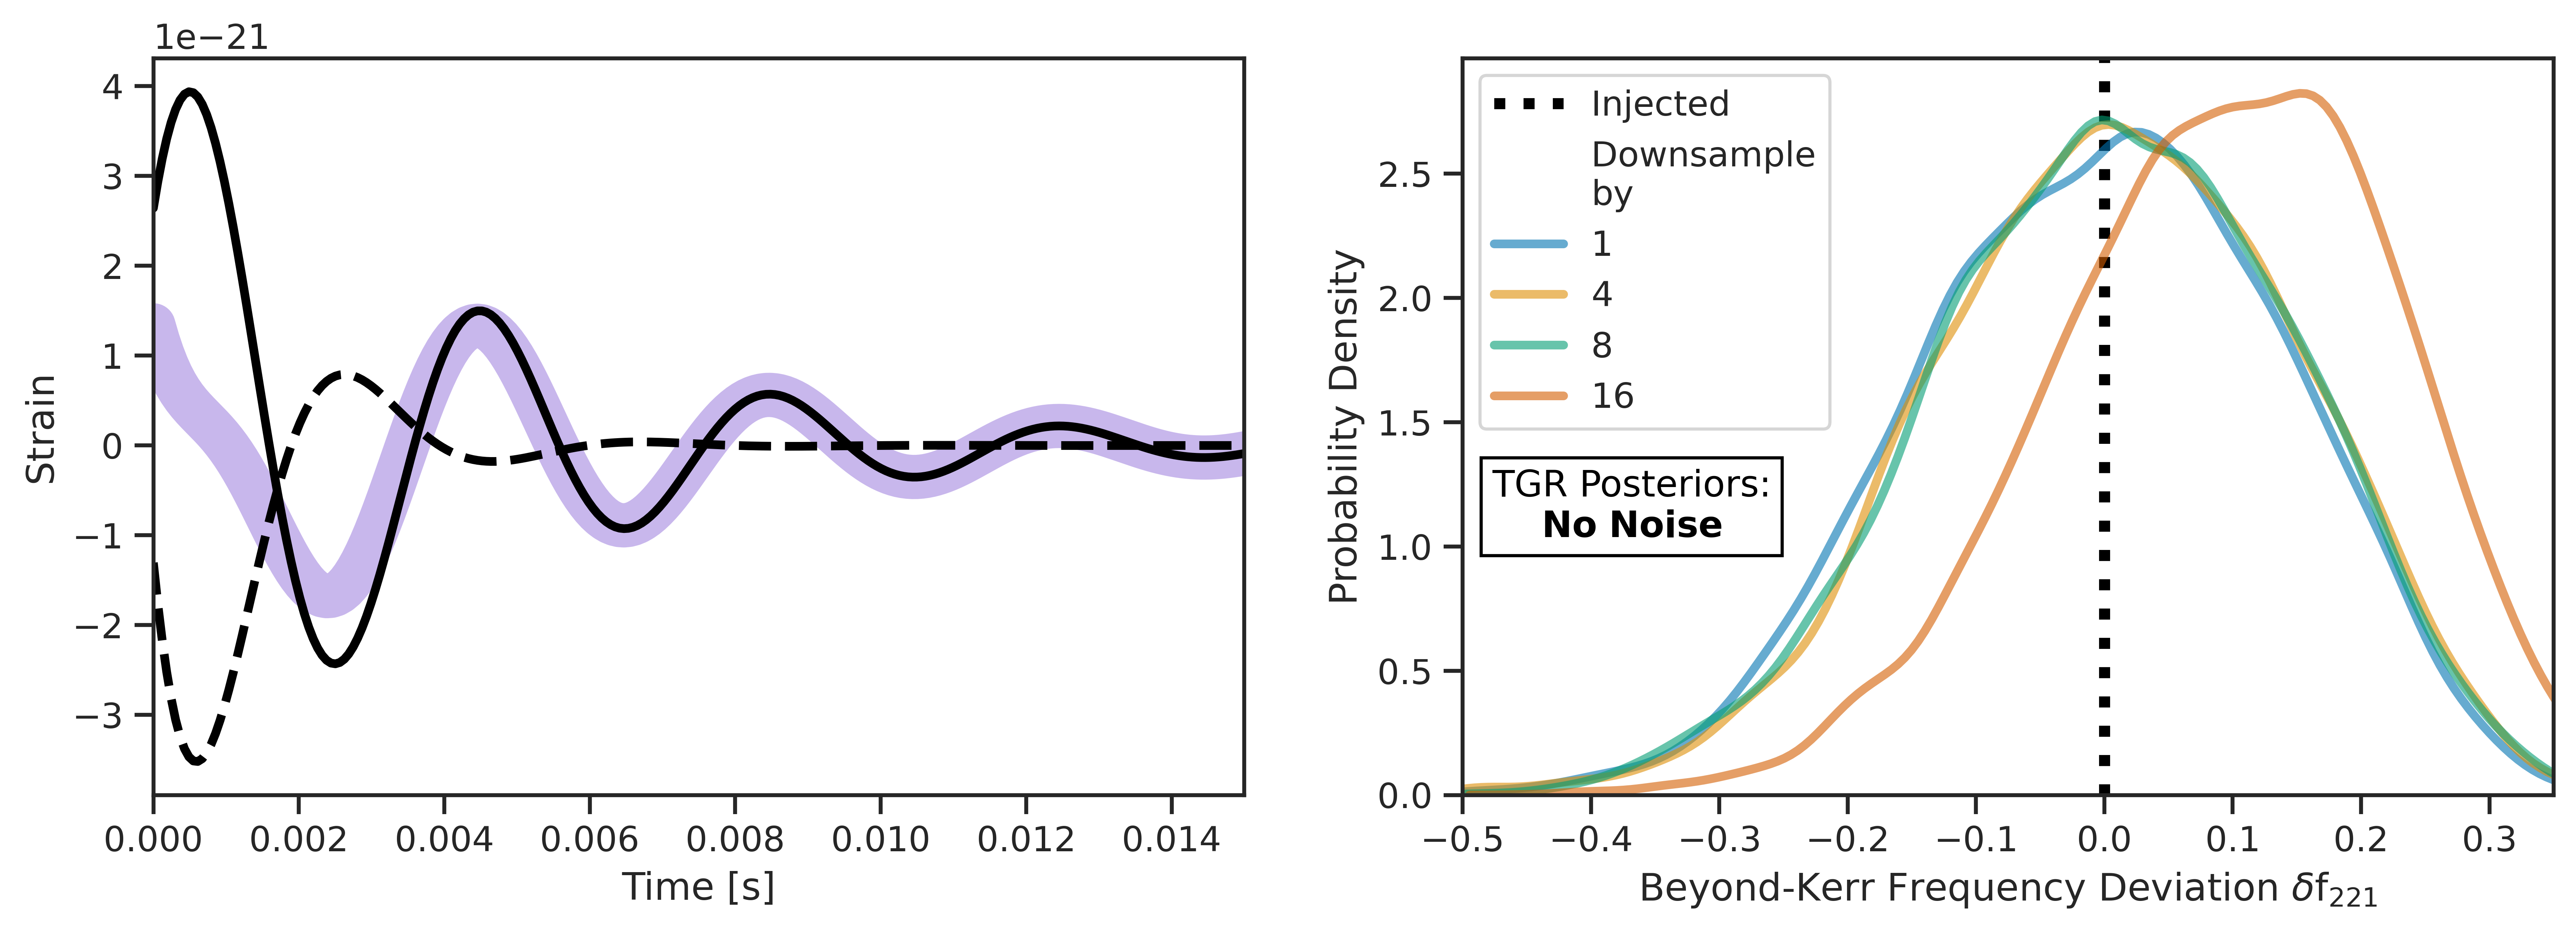

In [146]:
#plotting

fig, ax = plt.subplots(1,2, figsize = (2*fig_width,fig_height), dpi = 300)

cmap = sns.color_palette("colorblind")

small_lw = 2
med_lw = 2.75
big_lw = 3.5

quantile = .9

signal1 = damped_sinusoid(A=A[0], f=f_qnm[0], gamma=1/tau_qnm[0], phase=phase_qnm[0], times=times[int(len(times)/2):])
signal2 = damped_sinusoid(A=A[1], f=f_qnm[1], gamma=1/tau_qnm[1], phase=phase_qnm[1], times=times[int(len(times)/2):])

signal = signal1 + signal2

#Plotting for ax[0]

plot_ts = signal[t0:t0+dur].index
plot_ts = plot_ts-plot_ts[0]

ax[0].plot(plot_ts[::1], signal1[t0:t0+dur][::1].values, label = "Injected 220",ls = "-",lw=med_lw,color="black",alpha=1)
ax[0].plot(plot_ts[::1], signal2[t0:t0+dur][::1].values, label = "Injected 221",ls = "--",lw=med_lw,color="black",alpha=1)
ax[0].plot(plot_ts[::1], signal[t0:t0+dur][::1].values, label = "Full Injected Signal",ls = "-",lw=big_lw*4,color="mediumpurple",alpha=0.5,zorder=-10)


alpha = 0.33
ncols = 1

ax[0].set_xlim(0,0.0075*2)
ax[0].set_xlabel("Time [s]")
ax[0].set_ylabel("Strain")


#Plotting for ax[1]

ax[1].axvline(0, ls = ":", zorder = -100, color="black", label = "Injected",lw=big_lw)

ax[1].axvline(0, zorder = 10, color=None, label = "Downsample\nby",lw=0)

kde_dict = {}
alpha = 0.6
c_count = 0
#lw = small_lw
lw = med_lw
for k,v in results_dict.items():
    if k == 32:
        continue
    sns.kdeplot(v.posterior.df.sel(df_dim_0 = 1).values.flatten(),label = k, alpha = alpha, color=cmap[c_count],fill=False,lw=med_lw,ax=ax[1])
    c_count +=1
    
ax[1].set_xlim(-0.5,0.35)
#ax[1].set_ylim(0.45,2.3)
ax[1].set_xlabel("Beyond-Kerr Frequency Deviation "+r'$\delta$'+"f"+r'$_{221}$')
ax[1].set_ylabel("Probability Density")

ann_box_offset_x = 0.155
ann_box_offset_y = 0.35

ax[1].annotate("TGR Posteriors:\n" + r'$\bf{No~Noise}$', xy=[ax[1].get_xlim()[0]+(ax[1].get_xlim()[1]-ax[1].get_xlim()[0])*ann_box_offset_x, ax[1].get_ylim()[0]+(ax[1].get_ylim()[1]-ax[1].get_ylim()[0])*ann_box_offset_y], color="black", fontsize = fs_label*0.8, ha = "center", bbox=dict(boxstyle="square", fc = "white", ec="black"))
leg = ax[1].legend(loc="upper left")

#plt.savefig("/mnt/home/hsiegel/ceph/conditioning_data_studies/figures/TGR_bias",bbox_inches="tight")

## PSD Spike

### GW190521-like signal

In [259]:
results_dict = {}
acfs_dict = {}

for f in [x for x in sorted([y for y in os.listdir(results_dir) if ".csv" not in y and ".nc" in y and "GW190521" in y and "Lorentzianspike" in y],key = lambda x: float(x.split("dur")[1].split("s_")[0].replace("p",".")))]:
    print(f)
    results_dict[float(f.split("dur")[1].split("s_")[0].replace("p","."))] = az.from_netcdf(results_dir + f)
    
for f in [y for y in os.listdir(results_dir) if ".csv" in y and ".nc" not in y and "GW190521" in y and "dur0p2" in y]:
    print(f)
    acfs_dict["spike"] = ringdown.AutoCovariance(pd.read_csv(results_dir+f).values.T[1],pd.read_csv(results_dir+f).values.T[0])

for f in [y for y in os.listdir(results_dir) if ".csv" in y and ".nc" not in y and "GW190521" in y and "NOSPIKE" in y]:
    print(f)
    acfs_dict["NOspike"] = ringdown.AutoCovariance(pd.read_csv(results_dir+f).values.T[1],pd.read_csv(results_dir+f).values.T[0])

GW190521_NOnoise_LIGOWelchPSDDitialFilterLorentzianspike_fundamental_ds1_sr4096_dur0p05s_A1p2e-21_f67p489_ph5p34_tau0p0155_spikeA1p5e-45M67p489S0p05.nc
GW190521_NOnoise_LIGOWelchPSDDitialFilterLorentzianspike_fundamental_ds1_sr4096_dur0p1s_A1p2e-21_f67p489_ph5p34_tau0p0155_spikeA1p5e-45M67p489S0p05.nc
GW190521_NOnoise_LIGOWelchPSDDitialFilterLorentzianspike_fundamental_ds1_sr4096_dur0p2s_A1p2e-21_f67p489_ph5p34_tau0p0155_spikeA1p5e-45M67p489S0p05.nc
ACF_GW190521_NOnoise_LIGOWelchPSDDigitalFilterLorentzianspike_fundamental_dur0p2_flow10_ds1.csv
ACF_GW190521_NOnoise_LIGOWelchPSDDigitalFilterNOSPIKE_fundamental_dur0p05_flow20p0_ds1.csv


/tmp/ipykernel_2300017/700253292.py:83: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(["{:.2f}".format(x) for x in xticks-xticks[0]])


Text(69.629, 0.3381499631749676, 'Posteriors:\nNo Downsample\n$\\bf{No~Noise}$')

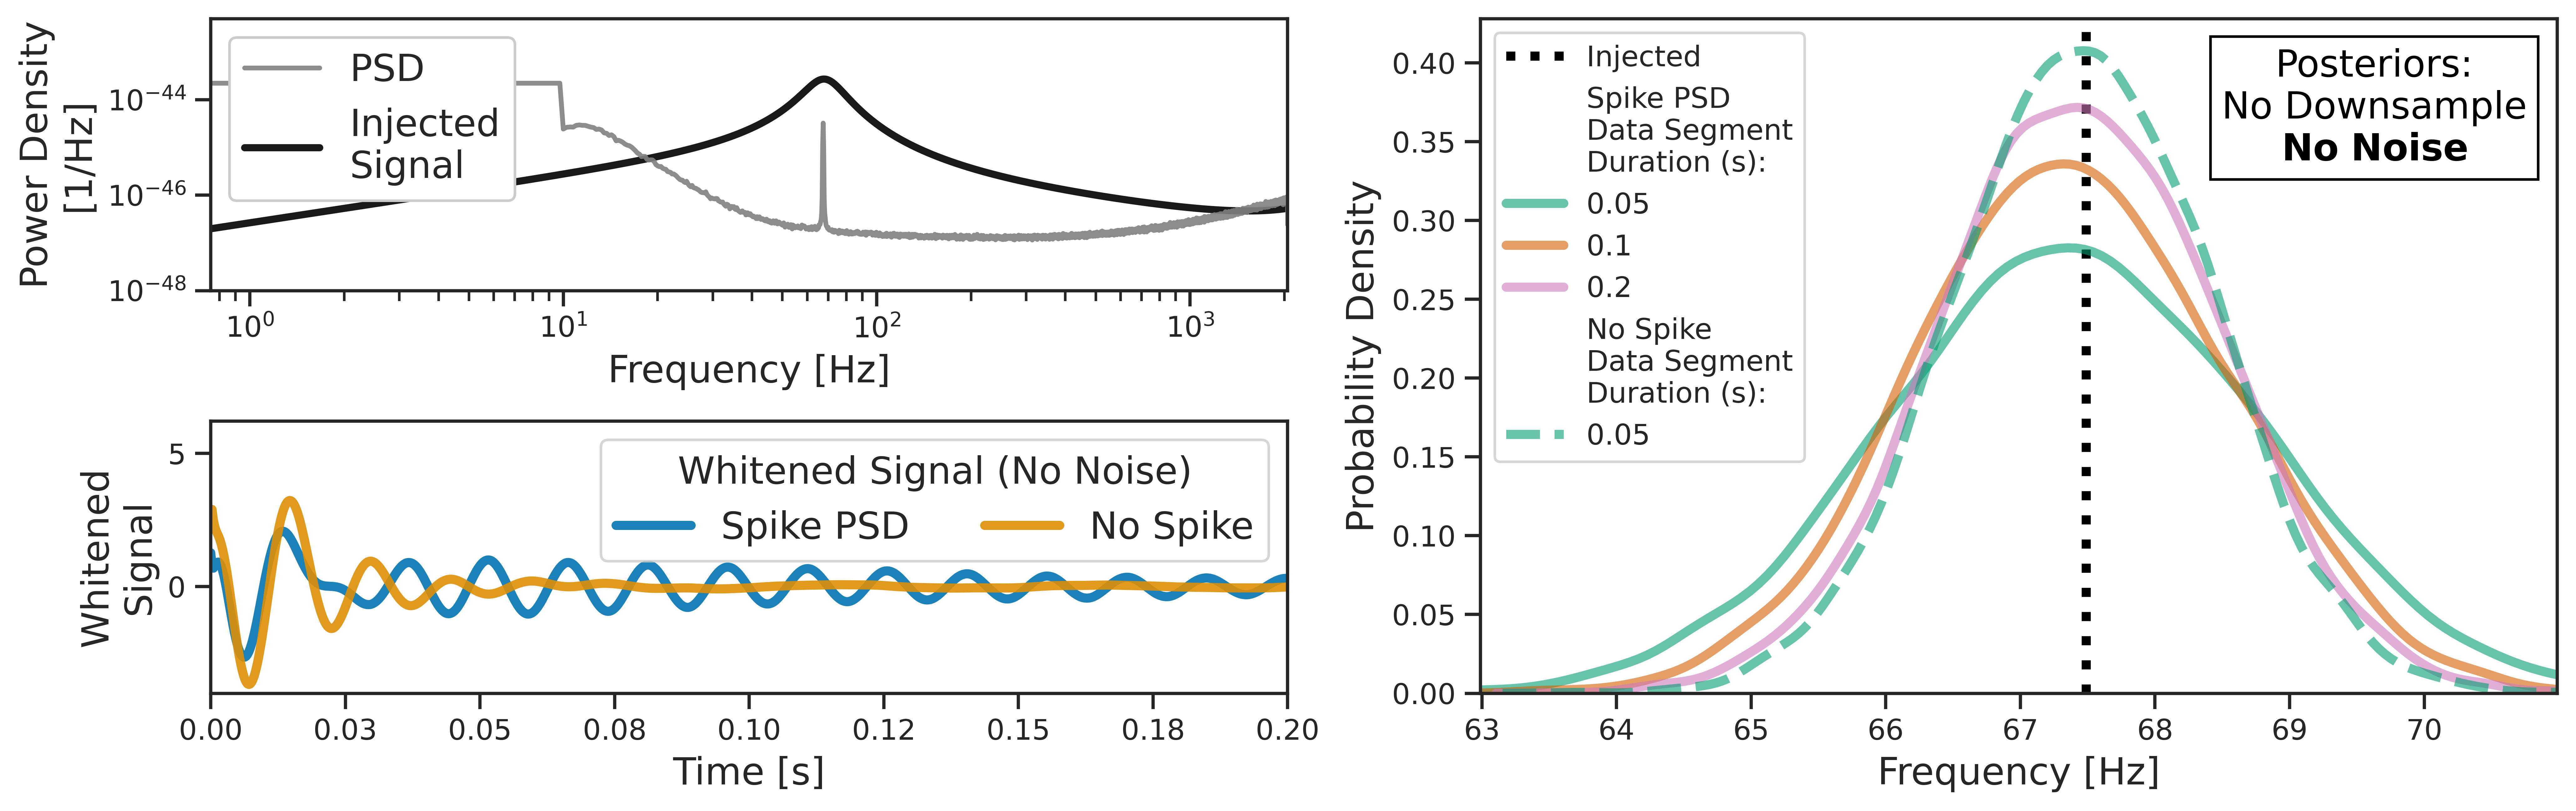

In [260]:
fig = plt.figure(constrained_layout=True, dpi = 300, figsize = (fig_width*2,fig_height))
gs_plot = gs(2, 2, figure=fig)

ax = []
ax1 = fig.add_subplot(gs_plot[0, 0])
ax2 = fig.add_subplot(gs_plot[1, 0])
ax3 = fig.add_subplot(gs_plot[:, 1])
ax.append(ax1)
ax.append(ax2)
ax.append(ax3)

cmap = sns.color_palette("colorblind")
#cmap = sns.color_palette("mako",n_colors=len(results_dict))

small_lw = 2
med_lw = 2.75
big_lw = 3.5

#ax[0]

# PSD parameters

#data parameters
sample_rate = 2**12
ds = 1
duration = 128
noise_td = generate_noise(sr=sample_rate/ds, rtrn_psd=False, lalpsd = True)
psd_analysis = acfs_dict["spike"].to_psd()
times = noise_td.index
delta_t = 1/sample_rate
t0 = duration/2

f_qnm = 67.489
A = 1.2e-21
tau_qnm = 0.0155
phase_qnm = 5.34 # radians

signal = damped_sinusoid(A=A, f=f_qnm, gamma=1/tau_qnm, phase=phase_qnm, times=times[int(len(times)/2):])

#number of samples per chain
draws = 2000

acf_analysis = acfs_dict["spike"]
        
c_count = 0
lw = med_lw
alpha = 0.9

ann_slope = -3.2 #slope for producing straight lines on loglog plot
b = np.log(5e-47)-ann_slope*np.log(8192) #y intercept for producing straight lines on loglog plot

ax[0].plot(psd_analysis.index, psd_analysis.values, color = "grey", lw = lw*2/3, ls = "-", zorder = 1, alpha = alpha,label = "PSD")
freqs_analysis = np.fft.rfftfreq(len(noise_td[t0:]), delta_t)
signal_FT = np.fft.rfft(signal[t0:].values)/sample_rate*2 # multiply by 2 to get power right
sig_power = ringdown.FrequencySeries(freqs_analysis*(signal_FT.real**2+signal_FT.imag**2),freqs_analysis)
ax[0].plot(sig_power, color = "black", lw=lw, zorder = -100,label = "Injected\nSignal",alpha=alpha)
c_count += 1

ax[0].legend(loc="upper left",fontsize=fs_label, framealpha=1)
ax[0].set_ylim(1e-48, 5e-43)
ax[0].set_xlim(0.75,sample_rate/2)
ax[0].set_yscale("log")
ax[0].set_xscale("log")
ax[0].set_xlabel('Frequency [Hz]', fontsize = fs_label)
ax[0].set_ylabel("Power Density\n[1/Hz]", fontsize = fs_label)
    
#ax[1]
alpha = 0.9
dur_whiten = 0.4
whtnd_sig = acf_analysis[0:dur_whiten].whiten(signal[t0:t0+dur_whiten]) #Spike whitening
ax[1].plot(whtnd_sig,label="Spike PSD",color=cmap[0],alpha=alpha,lw=big_lw)

acf_analysis2 = acfs_dict["NOspike"]
whtnd_sig2 = acf_analysis2[0:dur_whiten].whiten(signal[t0:t0+dur_whiten])
ax[1].plot(whtnd_sig2,label="No Spike",color=cmap[1],alpha=alpha,lw=big_lw) #No spike whitening


xmax = 0.2
ax[1].set_xlim(t0,t0+xmax)
ax[1].set_ylim(-4,6.2)

xticks = ax[1].get_xticks()
ax[1].set_xticklabels(["{:.2f}".format(x) for x in xticks-xticks[0]])

ax[1].set_xlabel('Time [s]',fontsize=fs_label)
ax[1].set_ylabel("Whitened\nSignal",fontsize=fs_label)

leg = ax[1].legend(loc="upper right",ncol=2,fontsize=fs_label)
leg.set_title(title="Whitened Signal (No Noise)",prop = {'size':fs_label})
#legend_title_left(leg)

#ax[2]

alpha = 0.6
c_count = 2
lw = big_lw

ax[2].axvline(f_qnm, ls = ":", zorder = -10, color="black", label = "Injected", lw=big_lw)
ax[2].axvline(f_qnm,label = "Spike PSD\nData Segment\nDuration (s):",lw = 0, color= None)

for k,v in results_dict.items():
    #if k > 0.05:
    #    alpha = 0.95
    #    lw = big_lw
    if type(k) is not str:
        sns.kdeplot(v.posterior.f.values.flatten(),label =k, linewidth=lw, alpha = alpha, ax = ax[2],color=cmap[c_count])
        c_count +=1
    else:
        sns.kdeplot(v.posterior.f.values.flatten(),label =k, linewidth=lw, alpha = alpha, ls="--", ax = ax[2],color="grey")
        
ax[2].axvline(f_qnm,label = "No Spike\nData Segment\nDuration (s):",lw = 0, color= None)
no_spike_result = az.from_netcdf("/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW190521_NOnoise_LIGOWelchPSDDitialFilter_fundamental_ds1_sr4096_dur0p05s_A1p2e-21_f67p489_ph5p34_tau0p0155.nc")
sns.kdeplot(no_spike_result.posterior.f.values.flatten(),label = 0.05, linewidth=lw, linestyle = "--", alpha = alpha, ax = ax[2],color=cmap[2])

ax[2].set_xlim(f_qnm-4.5,f_qnm+3.5)
ax[2].legend(loc = "upper left")
ax[2].set_xlabel('Frequency [Hz]', fontsize = fs_label)
ax[2].set_ylabel("Probability Density",fontsize = fs_label)
ann_box_offset_x = 0.83
ann_box_offset_y = 0.79
ax[2].annotate("Posteriors:\nNo Downsample\n"+r'$\bf{No~Noise}$', xy=[ax[2].get_xlim()[0]+(ax[2].get_xlim()[1]-ax[2].get_xlim()[0])*ann_box_offset_x, ax[2].get_ylim()[0]+(ax[2].get_ylim()[1]-ax[2].get_ylim()[0])*ann_box_offset_y], color="black", fontsize = fs_label, ha = "center", bbox=dict(boxstyle="square", fc = "white", ec="black"))

#plt.savefig("/mnt/home/hsiegel/ceph/conditioning_data_studies/figures/PSDspike_bias",bbox_inches="tight")

# Appendix

Note that if we were to convolve our time series with a filter, we would be multiplying the series in the frequency domain by the FT of the filter. This creates a filtered time series $\{y_{\text{filt}}(t)\}$, whose PSD is given by

&emsp;$S_{\text{filt}} (f) = |\tilde{K}(f)|^2~S(f)$,

where $\tilde{K}(f)$ is the FT of the time-domain filter.